In [3]:
import csv
import os
import random
import pickle
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import sklearn
import warnings
import skbold
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# dwMRI

# MISMATCH BETWEEN FOLDER NAME AND FILES IN STRUCTURAL MATRICES:

31024_Schaefer7n1000p_Tian_S4
- expected: 1000 + 54 = 1054 structures
- in fact: 216 structures = 200 + 16 (T1) => 31024_Schaefer7n200p_Tian_S1

31025_Schaefer7n200p_Tian_S1:
- expected: 200 + 16 = 216 structures
- in fact: 554 structures = 500 + 54 (T4) => 31025_Schaefer7n500p_Tian_S4

31026_Schaefer7n500p_Tian_S4
- expected: 500 + 54 = 516 structures
- in fact: 1054 structures = 1000 + 54 (T4)

# Combine and plot PLS results for DTI: IDP + Structural matrices

In [ ]:
# Merge PLS results for all DTI modalities
folds = ["0", "1", "2", "3", "4"]
modalities_idp = ["fa_tbss",  "fa_prob", "md_tbss", "md_prob", "l1_tbss",
                   "l1_prob", "l2_tbss", "l2_prob", "l3_tbss", "l3_prob",
                   "mo_tbss", "mo_prob", "od_tbss", "od_prob", "icvf_tbss",
                   "icvf_prob", "isovf_tbss", "isovf_prob"]

five_folds_dti_idp = []
for modality in modalities_idp:
    for fold in folds:
        dti = pd.read_csv(f'/PLS/brain/dti/dti_idp/fold_{fold}/models/{modality}_fold_{fold}_PLS_result.csv', header=None)
        dti.columns = ['Fold', 'Modality', 'n components', 'MSE', 'MAE', 'R2', 'Pearson r']
        five_folds_dti_idp.append(dti)
        five_folds_dti_idp_full = pd.concat(five_folds_dti_idp, ignore_index=False)

five_folds_dti_str = []
for fold in folds:
    files = sorted(glob.glob(f'/PLS/brain/dti/dti_struct/fold_{fold}/models/csv/*_fold_{fold}_PLS_result.csv'))
    for file in files:
        struct = pd.read_csv(file, header=None)
        struct.columns = ['Fold', 'Modality', 'n components', 'MSE', 'MAE', 'R2', 'Pearson r']
        five_folds_dti_str.append(struct)
        five_folds_dti_struct_full = pd.concat(five_folds_dti_str, ignore_index=False)

dti_full = pd.concat
dti_full = pd.concat([five_folds_dti_idp_full, five_folds_dti_struct_full], axis=0, ignore_index=True).round(decimals=3)

dti_full['Pearson r'] = dti_full['Pearson r'].astype(str).str.replace(r'PearsonRResult\(statistic=|pvalue=|\)', '', regex=True)
dti_full[['Pearson r', 'p-value']] = dti_full['Pearson r'].str.split(',', expand=True).astype(float).round(decimals=3)
dti_full['n components'] = dti_full['n components'].astype(str).str.replace(r"{'n_components':", '', regex=True)
dti_full['n components'] = dti_full['n components'].astype(str).str.replace(r"}", '', regex=True)
dti_full

,Fold,Modality,n components,MSE,MAE,R2,Pearson r,p-value
0,0,fa_tbss,7,0.476,0.549,0.052,0.229,0.0
1,1,fa_tbss,12,0.681,0.660,0.012,0.120,0.0
2,2,fa_tbss,3,0.765,0.700,0.022,0.149,0.0
3,3,fa_tbss,7,0.478,0.545,0.062,0.250,0.0
4,4,fa_tbss,6,0.494,0.554,0.059,0.244,0.0
...,...,...,...,...,...,...,...,...
205,4,31024_connectome_streamline_count,3,0.487,0.549,0.068,0.266,0.0
206,4,31025_connectome_fa,2,0.495,0.552,0.053,0.243,0.0
207,4,31025_connectome_mean_length,1,0.512,0.564,0.021,0.152,0.0
208,4,31025_connectome_sift2,2,0.490,0.548,0.064,0.264,0.0


In [ ]:
# Rename DTI modalities
modalities_dti_idp = ["fa_tbss",  "fa_prob", "md_tbss", "md_prob", "l1_tbss",
                   "l1_prob", "l2_tbss", "l2_prob", "l3_tbss", "l3_prob",
                   "mo_tbss", "mo_prob", "od_tbss", "od_prob", "icvf_tbss",
                   "icvf_prob", "isovf_tbss", "isovf_prob"]

new_names = ["FA TBSS", "FA Prob.", "MD TBSS", "MD Prob.", "L1 TBSS",
                   "L1 Prob.", "L2 TBSS", "L2 Prob.", "L3 TBSS", "L3 Prob.",
                   "MO TBSS", "MO Prob.", "OD TBSS", "OD Prob.", "ICVF TBSS",
                   "ICVF Prob.", "ISOVF TBSS", "ISOVF Prob."]

for modality, new in zip(modalities_dti_idp, new_names):
    dti_full['Modality'] = dti_full['Modality'].astype(str).str.replace(f'{modality}', f'{new}', regex=True)

struct_modal = ['31020', '31021', '31022', '31023', '31024', '31025']
new_names_dti = ['aparc_a2009s_MSA1', 'aparc_MSA1', 'Glasser_MSA1',
                 'Glasser_MSA4', 'Schaefer7n200p_MSA1', 'Schaefer7n500p_MSA4']

for struct, new_struct in zip(struct_modal, new_names_dti):
    dti_full['Modality'] = dti_full['Modality'].astype(str).str.replace(f'{struct}', f'{new_struct}', regex=True)

    
dti_full['Modality'] = dti_full['Modality'].astype(str).str.replace('_connectome_fa', ' Connectome FA', regex=True)
dti_full['Modality'] = dti_full['Modality'].astype(str).str.replace('_connectome_mean_length', ' Connectome Mean Length', regex=True)
dti_full['Modality'] = dti_full['Modality'].astype(str).str.replace('_connectome_sift2', ' Connectome SIFT2', regex=True)
dti_full['Modality'] = dti_full['Modality'].astype(str).str.replace('_10M', '', regex=True)
dti_full['Modality'] = dti_full['Modality'].astype(str).str.replace('_connectome_streamline_count', ' Connectome Streamline Count', regex=True)
dti_full['Modality'] = dti_full['Modality'].astype(str).str.replace('_MSA1', ' MSA I', regex=True)
dti_full['Modality'] = dti_full['Modality'].astype(str).str.replace('_MSA4', ' MSA IV', regex=True)
dti_full['Modality'] = dti_full['Modality'].astype(str).str.replace('aparc_a2009s', 'aparc a2009s', regex=True)
dti_full['Modality'] = dti_full['Modality'].astype(str).str.replace('L1_', 'L1 ', regex=True)
dti_full['Modality'] = dti_full['Modality'].astype(str).str.replace('Prob.', 'Probabilistic', regex=True)
dti_full.to_csv('/PLS/brain/DTI_PLS_Result_five_folds.csv', index=False)

In [32]:
with pd.option_context('display.max_rows', None):
    display(dti_full.sort_values(by='R2', ascending=True))

,Fold,Modality,n components,MSE,MAE,R2,Pearson r,p-value
159,2,Schaefer7n500p MSA IV Connectome Mean Length,1,0.781,0.709,0.000,0.078,0.000
57,2,MO Probabilistic,1,0.781,0.708,0.001,0.034,0.014
155,2,Schaefer7n200p MSA I Connectome Mean Length,1,0.780,0.708,0.001,0.065,0.000
56,1,MO Probabilistic,6,0.688,0.662,0.001,0.046,0.001
147,2,Glasser MSA I Connectome Mean Length,1,0.780,0.708,0.002,0.078,0.000
151,2,Glasser MSA IV Connectome Mean Length,1,0.780,0.708,0.002,0.081,0.000
67,2,OD Probabilistic,5,0.779,0.707,0.003,0.061,0.000
154,2,Schaefer7n200p MSA I Connectome FA,2,0.778,0.707,0.004,0.107,0.000
160,2,Schaefer7n500p MSA IV Connectome SIFT2,1,0.778,0.706,0.004,0.098,0.000
6,1,FA Probabilistic,7,0.686,0.662,0.004,0.076,0.000


In [33]:
# Average across folds
dti_pls_full_mean = dti_full[['R2', 'Pearson r', 'Modality', 'MSE', 'MAE']]
dti_pls_full_mean.groupby(['Modality']).mean().round(3).sort_values(by='R2', ascending=False)

,R2,Pearson r,MSE,MAE
Modality,,,,
aparc MSA I Connectome Streamline Count,0.052,0.226,0.569,0.596
aparc MSA I Connectome SIFT2,0.051,0.224,0.569,0.596
aparc a2009s MSA I Connectome Streamline Count,0.050,0.227,0.570,0.597
Schaefer7n200p MSA I Connectome Streamline Count,0.049,0.221,0.570,0.597
Schaefer7n200p MSA I Connectome SIFT2,0.048,0.221,0.571,0.598
aparc MSA I Connectome FA,0.048,0.214,0.571,0.597
aparc a2009s MSA I Connectome FA,0.047,0.213,0.572,0.597
aparc MSA I Connectome Mean Length,0.047,0.215,0.571,0.597
aparc a2009s MSA I Connectome SIFT2,0.046,0.215,0.572,0.598


## Plot Pearson's r distributions for each DTI modality

In [78]:
dti_pls_plot = dti_full.copy()
dti_grouped = dti_pls_plot.groupby('Modality')['Pearson r'].apply(list).reset_index(name='Pearson r values')
dti_grouped_sort = dti_pls_plot.groupby('Modality')['Pearson r'].mean().reset_index(name='Mean Pearson r values').sort_values(by='Mean Pearson r values', ascending = True)
dti_new_index = dti_grouped_sort.index
dti_grouped_reindex = dti_grouped.reindex(dti_new_index)
dti_grouped_reindex = dti_grouped_reindex.reset_index(drop=True)
dti_grouped_reindex

,Modality,Pearson r values
0,MO Probabilistic,"[0.086, 0.046, 0.034, 0.102, 0.111]"
1,OD Probabilistic,"[0.115, 0.064, 0.061, 0.125, 0.129]"
2,FA Probabilistic,"[0.175, 0.076, 0.085, 0.189, 0.18]"
3,Schaefer7n500p MSA IV Connectome Mean Length,"[0.154, 0.125, 0.078, 0.217, 0.152]"
4,ISOVF Probabilistic,"[0.165, 0.121, 0.108, 0.176, 0.182]"
5,MO TBSS,"[0.203, 0.108, 0.109, 0.196, 0.199]"
6,ICVF Probabilistic,"[0.194, 0.106, 0.107, 0.231, 0.188]"
7,OD TBSS,"[0.187, 0.111, 0.112, 0.202, 0.215]"
8,ISOVF TBSS,"[0.193, 0.126, 0.124, 0.222, 0.208]"
9,Glasser MSA I Connectome Mean Length,"[0.231, 0.123, 0.078, 0.223, 0.236]"


In [ ]:
dti_pls_stack_plot = dti_full.copy()
dti_grouped = dti_pls_plot.groupby('Modality')['Pearson r'].apply(list).reset_index(name='Pearson r values')
dti_grouped_sort = dti_pls_plot.groupby('Modality')['Pearson r'].mean().reset_index(name='Mean Pearson r values').sort_values(by='Mean Pearson r values', ascending = True)
dti_new_index = dti_grouped_sort.index
dti_grouped_reindex = dti_grouped.reindex(dti_new_index)
dti_grouped_reindex = dti_grouped_reindex.reset_index(drop=True)
dti_grouped_reindex 

In [ ]:
dti_pls_plot.to_csv('/PLS/brain/plot/dti_pls_plot.csv', index=False)
dti_grouped_reindex.to_csv('/PLS/brain/plot/dti_grouped_reindex.csv', index=False)

### Dot/Lineplot

In [33]:
dti_struct = [
'aparc MSA I Connectome Streamline Count',
'aparc MSA I Connectome SIFT2',
'aparc a2009s MSA I Connectome Streamline Count',
'Schaefer7n200p MSA I Connectome Streamline Count',
'Schaefer7n200p MSA I Connectome SIFT2',
'aparc MSA I Connectome FA',
'aparc a2009s MSA I Connectome FA',
'aparc MSA I Connectome Mean Length',
'aparc a2009s MSA I Connectome SIFT2',
'Schaefer7n200p MSA I Connectome FA',
'aparc a2009s MSA I Connectome Mean Length',
'Glasser MSA IV Connectome SIFT2',
'Glasser MSA IV Connectome Streamline Count',
'Glasser MSA IV Connectome FA',
'Schaefer7n500p MSA IV Connectome SIFT2',
'Schaefer7n500p MSA IV Connectome Streamline Count',
'Glasser MSA I Connectome FA',
'Schaefer7n200p MSA I Connectome Mean Length',
'Glasser MSA I Connectome Streamline Count',
'Schaefer7n500p MSA IV Connectome FA',
'Glasser MSA I Connectome SIFT2',
'Glasser MSA IV Connectome Mean Length',
'Glasser MSA I Connectome Mean Length',
'Schaefer7n500p MSA IV Connectome Mean Length'
]

dti_idp = [
'OD Probabilistic',
'MO Probabilistic',
'OD TBSS',
'ICVF Probabilistic',
'MO TBSS',
'ISOVF Probabilistic',
'FA Probabilistic',
'L2 Probabilistic',
'L1 Probabilistic',
'ISOVF TBSS',
'L3 Probabilistic',
'MD TBSS',
'MD Probabilistic',
'L2 TBSS',
'L3 TBSS',
'ICVF TBSS',
'L1 TBSS',
'FA TBSS'
]

### Add stacked model

In [ ]:
dti_pls = pd.read_csv('/PLS/brain/DTI_PLS_Result_five_folds.csv')
dti_stack = pd.read_csv('/PLS/brain/stacking/DTI_All_stacked_five_folds.csv')
dti_stack = dti_stack[dti_stack['Algorithm'] == 'rf']
dti_stack_rf = dti_stack[['Fold', 'Pearson r']]
dti_stack_rf['Modality'] = 'dwMRI Stacked (RF)'
dti_pls_plot = dti_pls[['Fold', 'Pearson r', 'Modality']]
dti_pls_stack_plot = pd.concat([dti_pls_plot, dti_stack_rf], axis=0)
dti_pls_stack_plot.to_csv('/PLS/brain/stacking/dti_pls_stack_plot.csv', index=False)
dti_pls_stack_plot

/tmp/ipykernel_70199/416086749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dti_stack_rf['Modality'] = 'dwMRI Stacked (RF)'


,Fold,Pearson r,Modality
0,0,0.229,FA TBSS
1,1,0.120,FA TBSS
2,2,0.149,FA TBSS
3,3,0.250,FA TBSS
4,4,0.244,FA TBSS
...,...,...,...
15,0,0.314,dwMRI Stacked (RF)
16,1,0.188,dwMRI Stacked (RF)
17,2,0.174,dwMRI Stacked (RF)
18,3,0.337,dwMRI Stacked (RF)


In [142]:
dti_pls_stack_grouped = dti_pls_stack_plot.groupby('Modality')['Pearson r'].apply(list).reset_index(name='Pearson r values')
dti_pls_stack_grouped_sort = dti_pls_stack_plot.groupby('Modality')['Pearson r'].mean().reset_index(name='Mean Pearson r values').sort_values(by='Mean Pearson r values', ascending = True)
dti_pls_stack_new_index = dti_pls_stack_grouped_sort.index
dti_pls_stack_grouped_reindex = dti_pls_stack_grouped.reindex(dti_pls_stack_new_index)
dti_pls_stack_grouped_reindex = dti_pls_stack_grouped_reindex.reset_index(drop=True)
dti_pls_stack_grouped_reindex

,Modality,Pearson r values
0,MO Probabilistic,"[0.086, 0.046, 0.034, 0.102, 0.111]"
1,OD Probabilistic,"[0.115, 0.064, 0.061, 0.125, 0.129]"
2,FA Probabilistic,"[0.175, 0.076, 0.085, 0.189, 0.18]"
3,Schaefer7n500p MSA IV Connectome Mean Length,"[0.154, 0.125, 0.078, 0.217, 0.152]"
4,ISOVF Probabilistic,"[0.165, 0.121, 0.108, 0.176, 0.182]"
5,MO TBSS,"[0.203, 0.108, 0.109, 0.196, 0.199]"
6,ICVF Probabilistic,"[0.194, 0.106, 0.107, 0.231, 0.188]"
7,OD TBSS,"[0.187, 0.111, 0.112, 0.202, 0.215]"
8,ISOVF TBSS,"[0.193, 0.126, 0.124, 0.222, 0.208]"
9,Glasser MSA I Connectome Mean Length,"[0.231, 0.123, 0.078, 0.223, 0.236]"


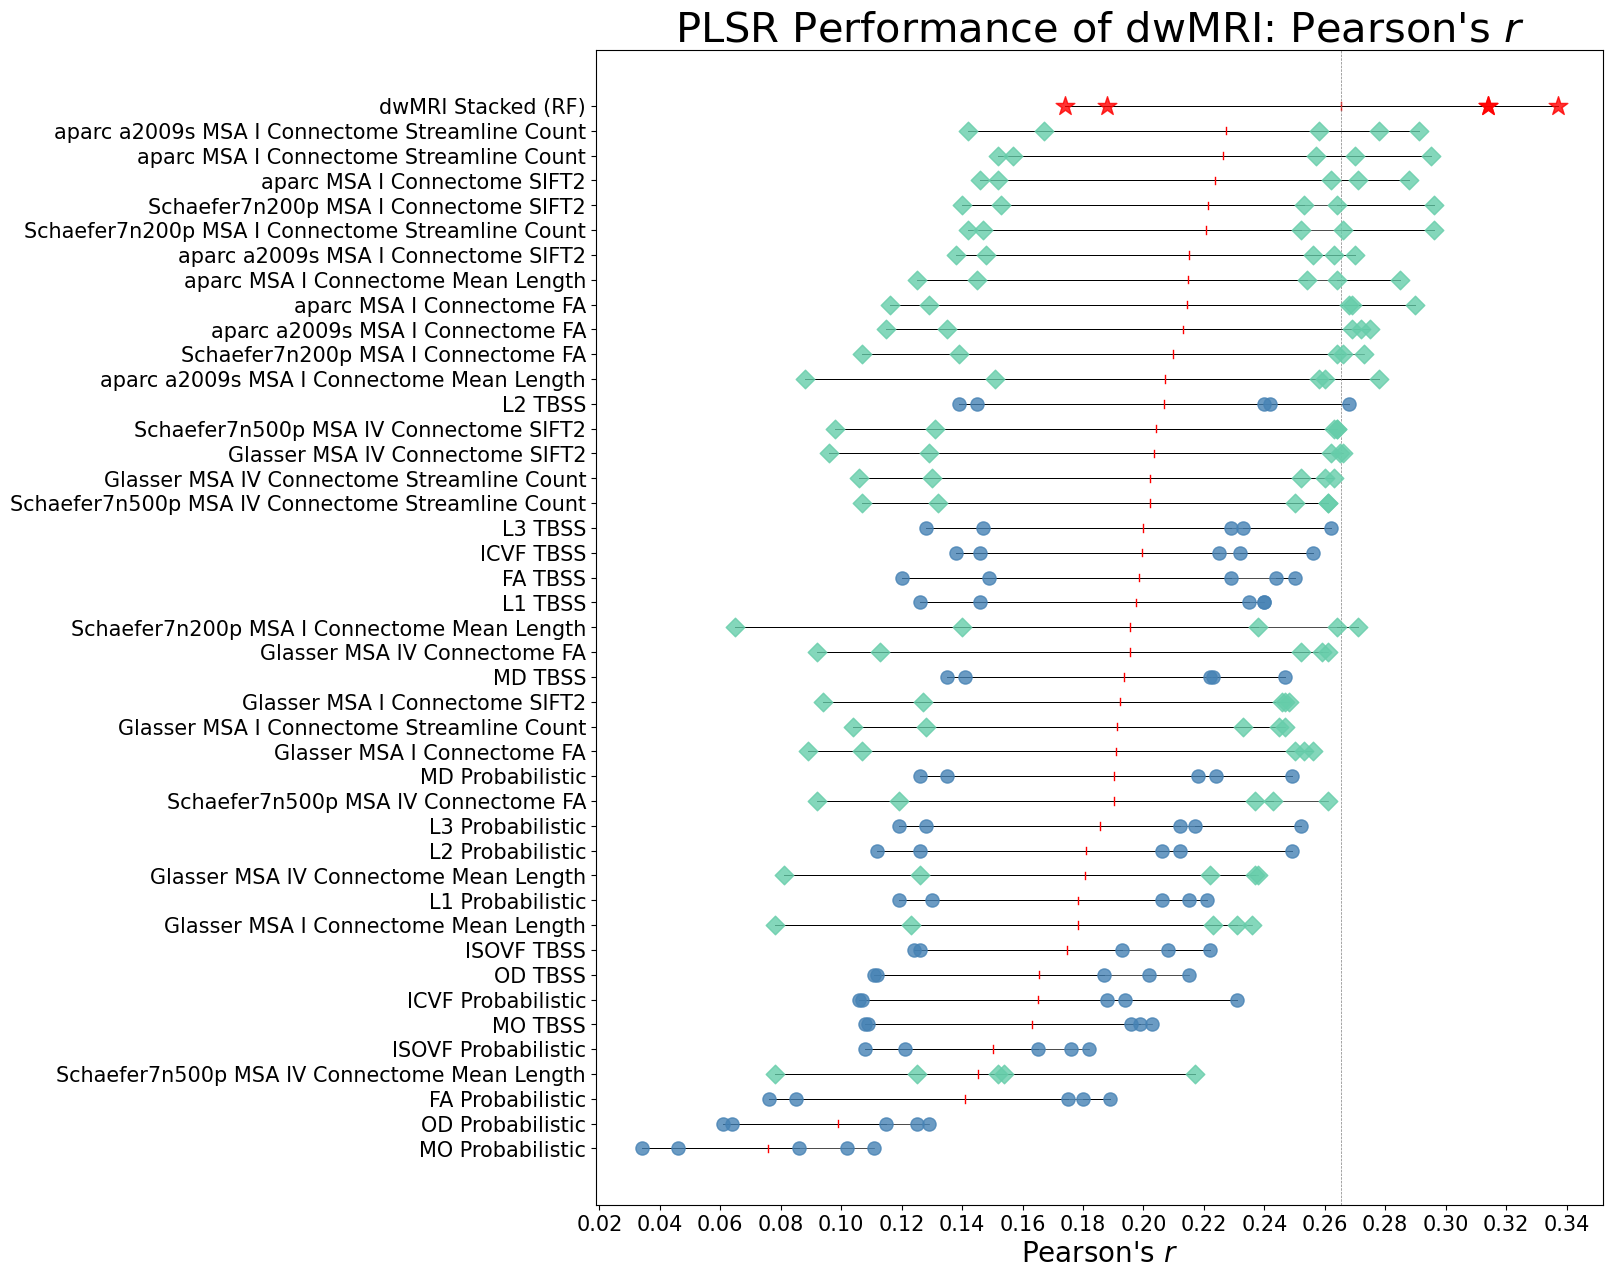

In [ ]:
plt.figure(figsize=(13, 15))

dti_full_r = dti_pls_stack_plot.copy()
dti_full_grouped_reindex_r = dti_pls_stack_grouped_reindex.copy()

# Create an empty plot without boxplot
for i, modality in enumerate(dti_pls_stack_grouped_reindex['Modality']):
    y = [i + 1] * len(dti_pls_stack_plot[dti_pls_stack_plot['Modality'] == modality]['Pearson r'])
    x = dti_pls_stack_plot[dti_pls_stack_plot['Modality'] == modality]['Pearson r']

    if modality in dti_struct:
        color = 'mediumaquamarine' #seagreen
        marker='D'
        s=90
    elif modality in dti_idp:
        color = 'steelblue'
        marker= 'o'
        s=90
    else:
        color = 'red'
        marker= '*'
        s=200
        
    plt.scatter(x, y, color=color, marker=marker, s=s, zorder=3,  alpha=0.8) #setting zorder=3 for the plt.scatter function ensures that the dots are drawn above the boxplot elements
    plt.plot(x, y, color='black', linewidth=0.5)

    # Calculate the mean across 5 folds and plot a red line
    mean_value = np.mean(dti_pls_stack_plot[dti_pls_stack_plot['Modality'] == modality]['Pearson r'])
    plt.plot([mean_value, mean_value], [i + 0.85, i + 1.15], color='red', linewidth=1)

    if modality == 'dwMRI Stacked (RF)':
        plt.axvline(x=mean_value, color='grey', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.02))
plt.yticks(range(1, len(dti_pls_stack_grouped_reindex['Modality']) + 1), dti_pls_stack_grouped_reindex['Modality'], fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel("Pearson's $r$", fontsize = 20)
plt.title("PLSR Performance of dwMRI: Pearson's $r$", fontsize = 30)
plt.show()

### Do all the same for R2

In [ ]:
dti_pls = pd.read_csv('/PLS/brain/DTI_PLS_Result_five_folds.csv')
dti_stack = pd.read_csv('/PLS/brain/stacking/DTI_All_stacked_five_folds.csv')
dti_stack = dti_stack[dti_stack['Algorithm'] == 'rf']
dti_stack_rf = dti_stack[['Fold', 'R2']]
dti_stack_rf['Modality'] = 'dwMRI Stacked (RF)'
dti_pls_plot = dti_pls[['Fold', 'R2', 'Modality']]
dti_pls_stack_plot_r2 = pd.concat([dti_pls_plot, dti_stack_rf], axis=0)

dti_pls_stack_grouped = dti_pls_stack_plot_r2.groupby('Modality')['R2'].apply(list).reset_index(name='R2 values')
dti_pls_stack_grouped_sort = dti_pls_stack_plot_r2.groupby('Modality')['R2'].mean().reset_index(name='Mean R2 values').sort_values(by='Mean R2 values', ascending = True)
dti_pls_stack_new_index = dti_pls_stack_grouped_sort.index
dti_pls_stack_grouped_reindex_r2 = dti_pls_stack_grouped.reindex(dti_pls_stack_new_index)
dti_pls_stack_grouped_reindex_r2 = dti_pls_stack_grouped_reindex_r2.reset_index(drop=True)

dti_pls_stack_plot_r2.to_csv('/PLS/brain/stacking/dti_pls_stack_plot_r2.csv', index=False)
dti_full_r2 = dti_pls_stack_plot_r2.copy()
dti_full_grouped_reindex_r2 = dti_pls_stack_grouped_reindex_r2.copy()


dti_pls_stack_grouped_reindex_r2

/tmp/ipykernel_70199/1085310062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dti_stack_rf['Modality'] = 'dwMRI Stacked (RF)'


,Modality,R2 values
0,MO Probabilistic,"[0.007, 0.001, 0.001, 0.01, 0.012]"
1,OD Probabilistic,"[0.013, 0.004, 0.003, 0.015, 0.016]"
2,Schaefer7n500p MSA IV Connectome Mean Length,"[0.022, 0.013, 0.0, 0.035, 0.021]"
3,FA Probabilistic,"[0.031, 0.004, 0.007, 0.036, 0.032]"
4,ISOVF Probabilistic,"[0.027, 0.015, 0.011, 0.031, 0.033]"
5,MO TBSS,"[0.041, 0.011, 0.012, 0.038, 0.039]"
6,OD TBSS,"[0.034, 0.011, 0.012, 0.041, 0.045]"
7,ICVF Probabilistic,"[0.037, 0.01, 0.011, 0.053, 0.035]"
8,Glasser MSA I Connectome Mean Length,"[0.046, 0.014, 0.002, 0.04, 0.05]"
9,Glasser MSA IV Connectome Mean Length,"[0.05, 0.014, 0.002, 0.04, 0.051]"


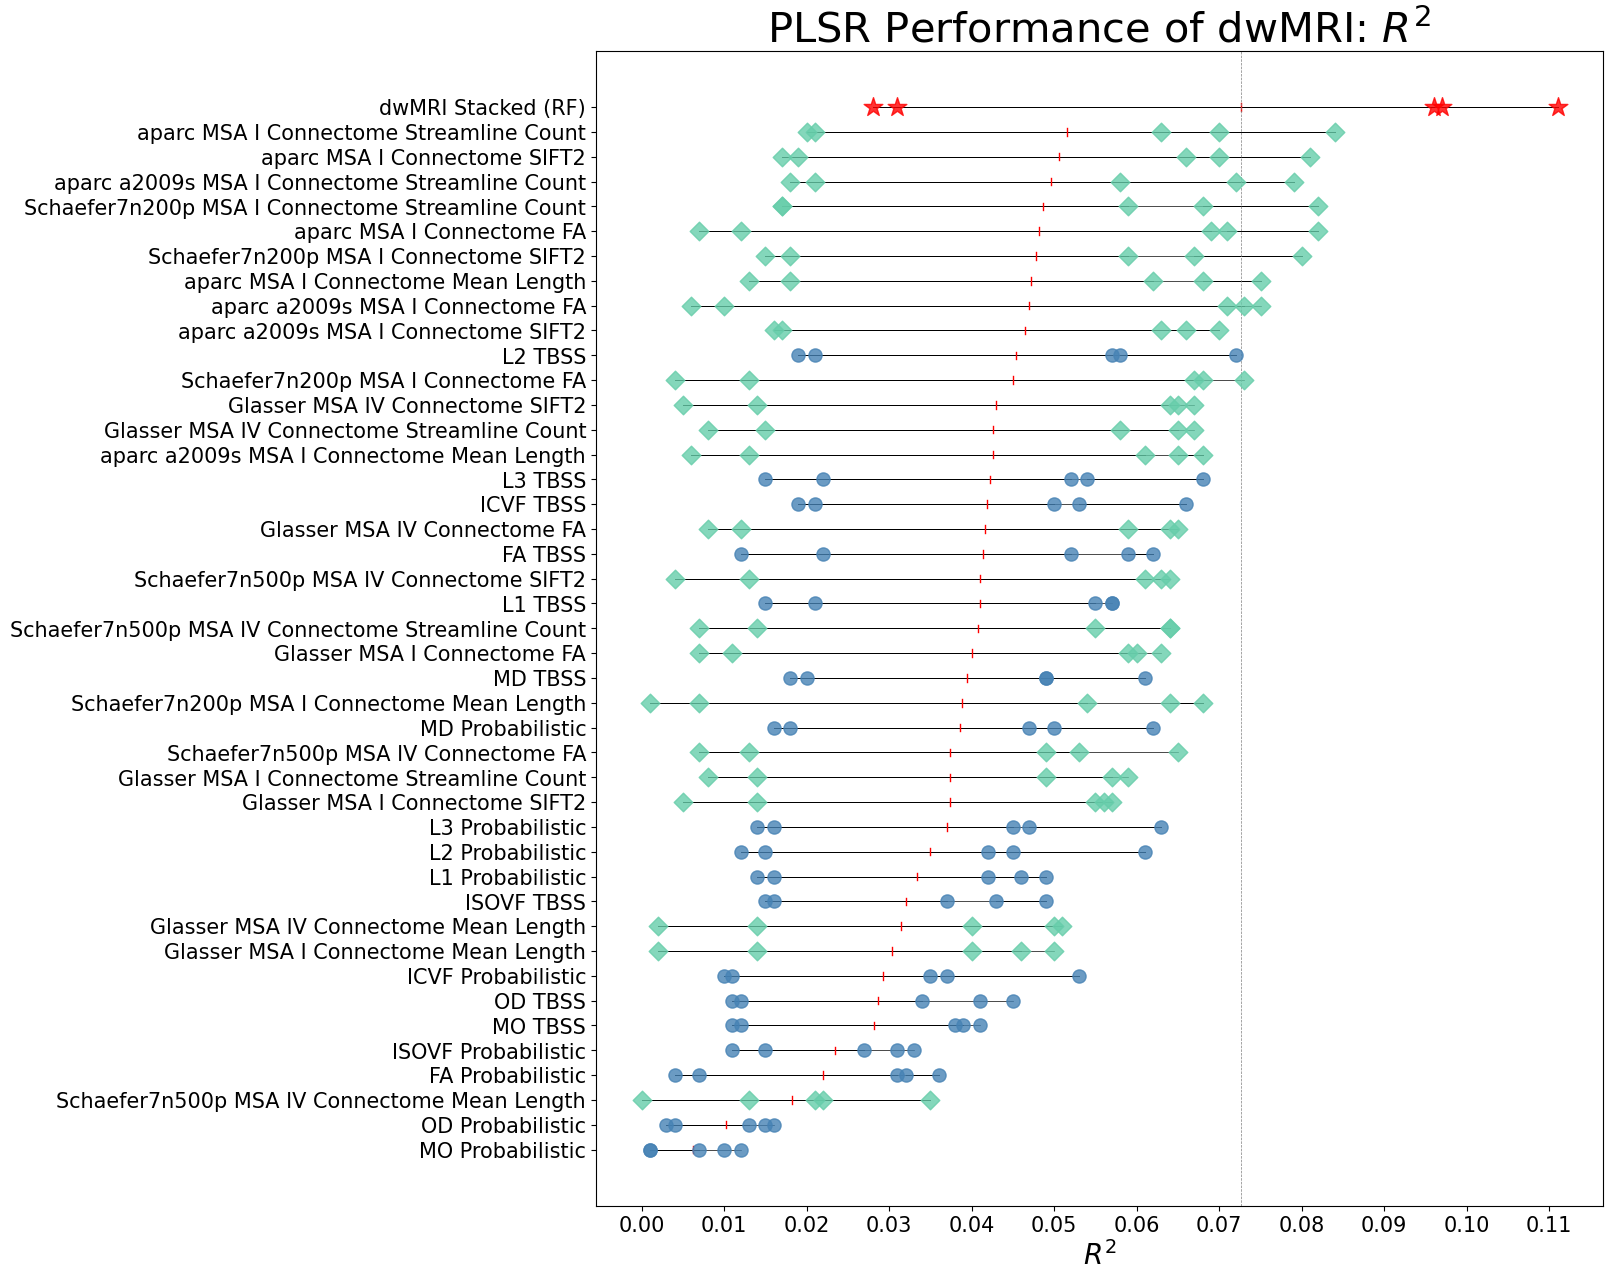

In [137]:
plt.figure(figsize=(13, 15))

# Create an empty plot without boxplot
for i, modality in enumerate(dti_pls_stack_grouped_reindex_r2['Modality']):
    y = [i + 1] * len(dti_pls_stack_plot_r2[dti_pls_stack_plot_r2['Modality'] == modality]['R2'])
    x = dti_pls_stack_plot_r2[dti_pls_stack_plot_r2['Modality'] == modality]['R2']

    if modality in dti_struct:
        color = 'mediumaquamarine' #seagreen
        marker='D'
        s=90
    elif modality in dti_idp:
        color = 'steelblue'
        marker= 'o'
        s=90
    else:
        color = 'red'
        marker= '*'
        s=200
        
    plt.scatter(x, y, color=color, marker=marker, s=s, zorder=3,  alpha=0.8)
    plt.plot(x, y, color='black', linewidth=0.5)

    # Calculate the mean across 5 folds and plot a red line
    mean_value = np.mean(dti_pls_stack_plot_r2[dti_pls_stack_plot_r2['Modality'] == modality]['R2'])
    plt.plot([mean_value, mean_value], [i + 0.85, i + 1.15], color='red', linewidth=1)

    if modality == 'dwMRI Stacked (RF)':
        plt.axvline(x=mean_value, color='grey', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.yticks(range(1, len(dti_pls_stack_grouped_reindex_r2['Modality']) + 1), dti_pls_stack_grouped_reindex_r2['Modality'], fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel("$R^2$", fontsize = 20)
plt.title("PLSR Performance of dwMRI: $R^2$", fontsize = 30)
plt.show()

# rsMRI

# Combine and plot PLS results for rsMRI: RS IDP (tangent and amplitudes 21/55) + Parcellations (full correlation)

Rename files in the folder: Schaefer

In [ ]:
# Rename files in the folder: Schaefer
folds = ['0', '1', '2', '3', '4']
for fold in folds:
    folder_path = f'/PLS/brain/rs/parcellation_main/UPDATE/fold_{fold}/result'
    for filename in os.listdir(folder_path):
        if '_arrays_' in filename:
            new_filename = filename.replace("_arrays_", "_")
            old_filepath = os.path.join(folder_path, filename)
            new_filepath = os.path.join(folder_path, new_filename)
            os.rename(old_filepath, new_filepath)
            
            print(f"Renamed {filename} to {new_filename}")

Renamed glasser_Tian_s3_arrays_partial_correlation_fold_0_PLS_result.csv to glasser_Tian_s3_partial_correlation_fold_0_PLS_result.csv
Renamed glasser_Tian_s2_arrays_partial_correlation_fold_0_PLS_result.csv to glasser_Tian_s2_partial_correlation_fold_0_PLS_result.csv
Renamed Schaefer7n200p_Tian_s4_arrays_full_correlation_with_id_fold_0_PLS_result.csv to Schaefer7n200p_Tian_s4_full_correlation_with_id_fold_0_PLS_result.csv
Renamed Schaefer7n200p_Tian_s2_arrays_partial_correlation_with_id_fold_0_full_result.csv to Schaefer7n200p_Tian_s2_partial_correlation_with_id_fold_0_full_result.csv
Renamed glasser_Tian_s4_arrays_partial_correlation_fold_0_full_result.csv to glasser_Tian_s4_partial_correlation_fold_0_full_result.csv
Renamed Schaefer7n200p_Tian_s3_arrays_partial_correlation_with_id_fold_0_PLS_result.csv to Schaefer7n200p_Tian_s3_partial_correlation_with_id_fold_0_PLS_result.csv
Renamed Schaefer7n200p_Tian_s4_arrays_full_correlation_with_id_fold_0_full_result.csv to Schaefer7n200p_Tian

In [ ]:
# Merge PLS results for RS
folds = ["0", "1", "2", "3", "4"]
atlases = [
'aparc_Tian_s1_full_correlation', 
'aparc_2009_Tian_s1_full_correlation',
'glasser_Tian_s1_full_correlation',
'glasser_Tian_s4_full_correlation',
'Schaefer7n200p_Tian_s1_full_correlation',
'Schaefer7n500p_Tian_s4_full_correlation']

five_folds_ts_fc = []

for atlas in atlases:
    for fold in folds:
        pls = pd.read_csv(f'/PLS/brain/rs/parcellation_main/rs_matched_to_dti/fold_{fold}/result/{atlas}_fold_{fold}_PLS_result.csv', header=None)
        pls.columns = ['Fold', 'Modality', 'n components', 'MSE', 'MAE', 'R2', 'Pearson r']
        five_folds_ts_fc.append(pls)
        five_folds_ts_full_corr_full = pd.concat(five_folds_ts_fc, ignore_index=False)


################################ main_modalities
folds = ["0", "1", "2", "3", "4"]
amplitudes = [
'amplitudes_21',
'amplitudes_55']

five_folds_ica_amplitudes = []
for a in amplitudes:
    for fold in folds:
        pls = pd.read_csv(f'/PLS/brain/rs/ica_main/fold_{fold}/models/csv/{a}_fold_{fold}_PLS_result.csv', header=None)
        pls.columns = ['Fold', 'Modality', 'n components', 'MSE', 'MAE', 'R2', 'Pearson r']
        five_folds_ica_amplitudes.append(pls)
        five_folds_ica_amplitudes_full = pd.concat(five_folds_ica_amplitudes, ignore_index=False)

#################################### tangent IDP
five_folds_ica_tangent = []
tangent = ['tangent_matrices_21', 'tangent_matrices_55']
for tg in tangent:
    for fold in folds:
        tangent = pd.read_csv(f'/PLS/brain/rs/ica_tangent/fold_{fold}/models/csv/{tg}_fold_{fold}_PLS_result.csv', header=None)
        tangent.columns = ['Fold', 'Modality', 'n components', 'MSE', 'MAE', 'R2', 'Pearson r']
        five_folds_ica_tangent.append(tangent)
        five_folds_ica_tangent_full = pd.concat(five_folds_ica_tangent, ignore_index=False)

rs_pls_full = pd.concat([five_folds_ts_full_corr_full, five_folds_ica_amplitudes_full, five_folds_ica_tangent_full], axis=0, ignore_index=True).round(decimals=3)

rs_pls_full['Pearson r'] = rs_pls_full['Pearson r'].astype(str).str.replace(r'PearsonRResult\(statistic=|pvalue=|\)', '', regex=True)
rs_pls_full[['Pearson r', 'p-value']] = rs_pls_full['Pearson r'].str.split(',', expand=True).astype(float).round(decimals=3)
rs_pls_full['n components'] = rs_pls_full['n components'].astype(str).str.replace(r"{'n_components':", '', regex=True)
rs_pls_full['n components'] = rs_pls_full['n components'].astype(str).str.replace(r"}", '', regex=True)
rs_pls_full['Modality'] = rs_pls_full['Modality'].astype(str).str.replace(r"\['Schaefer7n500p_Tian_s4'\]", 'Schaefer7n500p_Tian_s4_full_correlation', regex=True)
rs_pls_full.to_csv('/PLS/brain/RS_PLS_Result_five_folds.csv', index=False)

with pd.option_context('display.max_rows', None):
    display(rs_pls_full)

,Fold,Modality,n components,MSE,MAE,R2,Pearson r,p-value
0,0,aparc_Tian_s1_full_correlation,8,0.459,0.540,0.070,0.272,0.0
1,1,aparc_Tian_s1_full_correlation,6,0.663,0.649,0.033,0.192,0.0
2,2,aparc_Tian_s1_full_correlation,6,0.755,0.696,0.031,0.186,0.0
3,3,aparc_Tian_s1_full_correlation,8,0.468,0.542,0.063,0.259,0.0
4,4,aparc_Tian_s1_full_correlation,7,0.491,0.553,0.061,0.253,0.0
5,0,aparc_2009_Tian_s1_full_correlation,7,0.455,0.537,0.079,0.290,0.0
6,1,aparc_2009_Tian_s1_full_correlation,5,0.668,0.651,0.027,0.187,0.0
7,2,aparc_2009_Tian_s1_full_correlation,4,0.765,0.701,0.020,0.157,0.0
8,3,aparc_2009_Tian_s1_full_correlation,7,0.466,0.541,0.068,0.273,0.0
9,4,aparc_2009_Tian_s1_full_correlation,7,0.491,0.554,0.060,0.260,0.0


Rename modalities

In [ ]:
rs_pls_plot = rs_pls_full.copy()
rs_pls_plot['Modality'] = rs_pls_plot['Modality'].astype(str).str.replace("aparc_Tian_s1_full_correlation", 'aparc MSA I Full correlation', regex=True)
rs_pls_plot['Modality'] = rs_pls_plot['Modality'].astype(str).str.replace("aparc_2009_Tian_s1_full_correlation", 'aparc a2009s MSA I Full correlation', regex=True)
rs_pls_plot['Modality'] = rs_pls_plot['Modality'].astype(str).str.replace("glasser_Tian_s1_arrays_full_correlation", 'Glasser MSA I Full correlation', regex=True)
rs_pls_plot['Modality'] = rs_pls_plot['Modality'].astype(str).str.replace("glasser_Tian_s4_arrays_full_correlation", 'Glasser MSA IV Full correlation', regex=True)
rs_pls_plot['Modality'] = rs_pls_plot['Modality'].astype(str).str.replace("Schaefer7n200p_tian_s1_full_correlation", 'Schaefer7n200p MSA I Full correlation', regex=True)
rs_pls_plot['Modality'] = rs_pls_plot['Modality'].astype(str).str.replace("Schaefer7n500p_Tian_s4_full_correlation", 'Schaefer7n500p MSA IV Full correlation', regex=True)
rs_pls_plot['Modality'] = rs_pls_plot['Modality'].astype(str).str.replace("amplitudes_21", 'Amplitudes 21 IC', regex=True)
rs_pls_plot['Modality'] = rs_pls_plot['Modality'].astype(str).str.replace("amplitudes_55", 'Amplitudes 55 IC', regex=True)
rs_pls_plot['Modality'] = rs_pls_plot['Modality'].astype(str).str.replace("tangent_matrices_21", 'Tangent matrices 21 IC', regex=True)
rs_pls_plot['Modality'] = rs_pls_plot['Modality'].astype(str).str.replace("tangent_matrices_55", 'Tangent matrices 55 IC', regex=True)
rs_pls_plot.to_csv('/PLS/brain/RS_PLS_Result_five_folds_renamed.csv', index=False)
rs_pls_plot

,Fold,Modality,n components,MSE,MAE,R2,Pearson r,p-value
0,0,aparc MSA I Full correlation,8,0.459,0.540,0.070,0.272,0.0
1,1,aparc MSA I Full correlation,6,0.663,0.649,0.033,0.192,0.0
2,2,aparc MSA I Full correlation,6,0.755,0.696,0.031,0.186,0.0
3,3,aparc MSA I Full correlation,8,0.468,0.542,0.063,0.259,0.0
4,4,aparc MSA I Full correlation,7,0.491,0.553,0.061,0.253,0.0
5,0,aparc a2009s MSA I Full correlation,7,0.455,0.537,0.079,0.290,0.0
6,1,aparc a2009s MSA I Full correlation,5,0.668,0.651,0.027,0.187,0.0
7,2,aparc a2009s MSA I Full correlation,4,0.765,0.701,0.020,0.157,0.0
8,3,aparc a2009s MSA I Full correlation,7,0.466,0.541,0.068,0.273,0.0
9,4,aparc a2009s MSA I Full correlation,7,0.491,0.554,0.060,0.260,0.0


In [91]:
# Average across folds
rs_pls_full_mean = rs_pls_plot[['R2', 'Pearson r', 'Modality', 'MSE', 'MAE']]
rs_pls_full_mean.groupby(['Modality']).mean().round(3).sort_values(by='R2', ascending=False)

,R2,Pearson r,MSE,MAE
Modality,,,,
Tangent matrices 55 IC,0.088,0.302,0.552,0.587
Schaefer7n200p MSA I Full correlation,0.071,0.271,0.557,0.589
Schaefer7n500p MSA IV Full correlation,0.058,0.252,0.563,0.593
Glasser MSA I Full correlation,0.057,0.249,0.564,0.593
Tangent matrices 21 IC,0.054,0.232,0.571,0.599
Glasser MSA IV Full correlation,0.053,0.243,0.566,0.595
aparc MSA I Full correlation,0.052,0.232,0.567,0.596
aparc a2009s MSA I Full correlation,0.051,0.233,0.569,0.597
Amplitudes 55 IC,0.019,0.140,0.590,0.608


## Plot Pearson's r distributions for each RS modality

In [ ]:
rs_grouped = rs_pls_plot.groupby('Modality')['Pearson r'].apply(list).reset_index(name='Pearson r values')
rs_grouped_sort = rs_pls_plot.groupby('Modality')['Pearson r'].mean().reset_index(name='Mean Pearson r values').sort_values(by='Mean Pearson r values', ascending = True)
new_index = rs_grouped_sort.index
rs_grouped_reindex = rs_grouped.reindex(new_index)
rs_grouped_reindex = rs_grouped_reindex.reset_index(drop=True)
rs_pls_plot.to_csv('/PLS/brain/plot/rs_pls_plot.csv', index=False)
rs_grouped_reindex.to_csv('/PLS/brain/plot/rs_grouped_reindex.csv', index=False)
rs_grouped_reindex

,Modality,Pearson r values
0,Amplitudes 21 IC,"[0.141, 0.065, 0.085, 0.132, 0.138]"
1,Amplitudes 55 IC,"[0.169, 0.1, 0.121, 0.172, 0.136]"
2,Tangent matrices 21 IC,"[0.293, 0.188, 0.189, 0.246, 0.243]"
3,aparc MSA I Full correlation,"[0.272, 0.192, 0.186, 0.259, 0.253]"
4,aparc a2009s MSA I Full correlation,"[0.29, 0.187, 0.157, 0.273, 0.26]"
5,Glasser MSA IV Full correlation,"[0.276, 0.199, 0.184, 0.28, 0.275]"
6,Glasser MSA I Full correlation,"[0.295, 0.201, 0.184, 0.29, 0.273]"
7,Schaefer7n500p MSA IV Full correlation,"[0.295, 0.21, 0.186, 0.294, 0.277]"
8,Schaefer7n200p MSA I Full correlation,"[0.335, 0.216, 0.195, 0.299, 0.311]"
9,Tangent matrices 55 IC,"[0.369, 0.242, 0.237, 0.327, 0.333]"


### Dot/Lineplot

In [ ]:
rs_pls_plot['Modality'].unique()

array(['aparc MSA I Full correlation',
       'aparc a2009s MSA I Full correlation',
       'Glasser MSA I Full correlation',
       'Glasser MSA IV Full correlation',
       'Schaefer7n200p MSA I Full correlation',
       'Schaefer7n500p MSA IV Full correlation', 'Amplitudes 21 IC',
       'Amplitudes 55 IC', 'Tangent matrices 21 IC',
       'Tangent matrices 55 IC'], dtype=object)

In [66]:
rs_parcellations = [
'aparc MSA I Full correlation',
'aparc a2009s MSA I Full correlation',
'Glasser MSA I Full correlation',
'Glasser MSA IV Full correlation',
'Schaefer7n200p MSA I Full correlation',
'Schaefer7n500p MSA IV Full correlation'
]

rs_idp = [
'Amplitudes 21 IC',
'Amplitudes 55 IC',
'Tangent matrices 21 IC',
'Tangent matrices 55 IC'
]

### Add stacked model

In [ ]:
rs_pls = pd.read_csv('/PLS/brain/plot/rs_pls_plot.csv')
rs_stack = pd.read_csv('/PLS/brain/stacking/RS_IDP_Timeseries_best_metrics_stacked_five_folds.csv')

rs_stack = rs_stack[rs_stack['Algorithm'] == 'rf']
rs_stack_rf = rs_stack[['Fold', 'Pearson r']]
rs_stack_rf['Modality'] = 'rsMRI Stacked (RF)'
rs_pls_plot = rs_pls[['Fold', 'Pearson r', 'Modality']]
rs_pls_stack_plot = pd.concat([rs_pls_plot, rs_stack_rf], axis=0)
rs_pls_stack_plot

/tmp/ipykernel_70199/55399224.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rs_stack_rf['Modality'] = 'rsMRI Stacked (RF)'


,Fold,Pearson r,Modality
0,0,0.272,aparc MSA I Full correlation
1,1,0.192,aparc MSA I Full correlation
2,2,0.186,aparc MSA I Full correlation
3,3,0.259,aparc MSA I Full correlation
4,4,0.253,aparc MSA I Full correlation
5,0,0.290,aparc a2009s MSA I Full correlation
6,1,0.187,aparc a2009s MSA I Full correlation
7,2,0.157,aparc a2009s MSA I Full correlation
8,3,0.273,aparc a2009s MSA I Full correlation
9,4,0.260,aparc a2009s MSA I Full correlation


In [17]:
rs_pls_stack_grouped = rs_pls_stack_plot.groupby('Modality')['Pearson r'].apply(list).reset_index(name='Pearson r values')
rs_pls_stack_grouped_sort = rs_pls_stack_plot.groupby('Modality')['Pearson r'].mean().reset_index(name='Mean Pearson r values').sort_values(by='Mean Pearson r values', ascending = True)
rs_pls_stack_new_index = rs_pls_stack_grouped_sort.index
rs_pls_stack_grouped_reindex = rs_pls_stack_grouped.reindex(rs_pls_stack_new_index)
rs_pls_stack_grouped_reindex = rs_pls_stack_grouped_reindex.reset_index(drop=True)
rs_pls_stack_grouped_reindex

,Modality,Pearson r values
0,Amplitudes 21 IC,"[0.141, 0.065, 0.085, 0.132, 0.138]"
1,Amplitudes 55 IC,"[0.169, 0.1, 0.121, 0.172, 0.136]"
2,Tangent matrices 21 IC,"[0.293, 0.188, 0.189, 0.246, 0.243]"
3,aparc MSA I Full correlation,"[0.272, 0.192, 0.186, 0.259, 0.253]"
4,aparc a2009s MSA I Full correlation,"[0.29, 0.187, 0.157, 0.273, 0.26]"
5,Glasser MSA IV Full correlation,"[0.276, 0.199, 0.184, 0.28, 0.275]"
6,Glasser MSA I Full correlation,"[0.295, 0.201, 0.184, 0.29, 0.273]"
7,Schaefer7n500p MSA IV Full correlation,"[0.295, 0.21, 0.186, 0.294, 0.277]"
8,Schaefer7n200p MSA I Full correlation,"[0.335, 0.216, 0.195, 0.299, 0.311]"
9,Tangent matrices 55 IC,"[0.369, 0.242, 0.237, 0.327, 0.333]"


In [ ]:
rs_full_r = rs_pls_stack_plot.copy()
rs_pls_stack_plot.to_csv('/PLS/brain/stacking/rs_pls_stack_plot.csv', index=False)
rs_full_grouped_reindex_r = rs_pls_stack_grouped_reindex.copy()

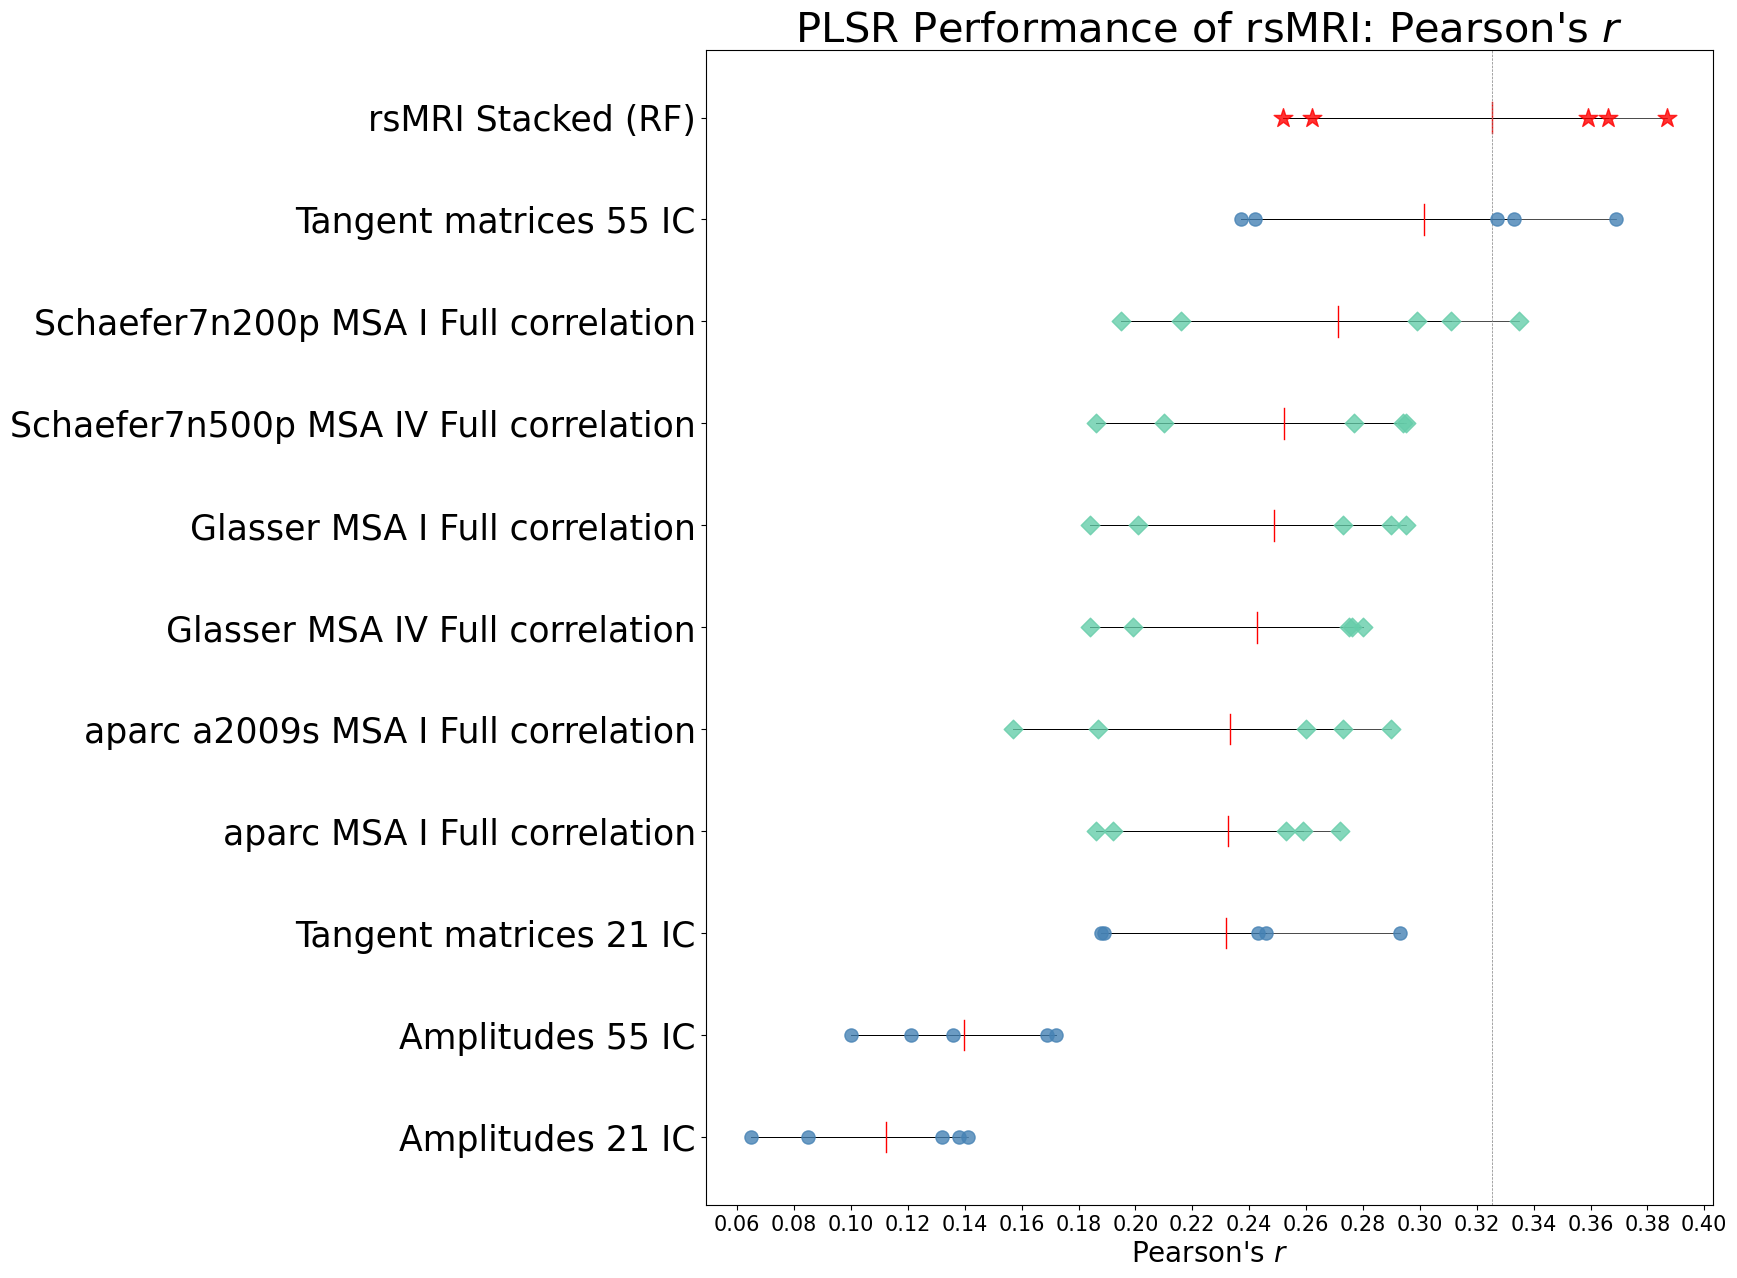

In [133]:
plt.figure(figsize=(13, 15))

# Create an empty plot without boxplot
for i, modality in enumerate(rs_pls_stack_grouped_reindex['Modality']):
    y = [i + 1] * len(rs_pls_stack_plot[rs_pls_stack_plot['Modality'] == modality]['Pearson r'])
    x = rs_pls_stack_plot[rs_pls_stack_plot['Modality'] == modality]['Pearson r']

    if modality in rs_parcellations:
        color = 'mediumaquamarine' #seagreen
        marker='D'
        s=90
    elif modality in rs_idp:
        color = 'steelblue'
        marker= 'o'
        s=90
    else:
        color = 'red'
        marker= '*'
        s=200
        
    plt.scatter(x, y, color=color, marker=marker, s=s, zorder=3,  alpha=0.8) #setting zorder=3 for the plt.scatter function ensures that the dots are drawn above the boxplot elements
    plt.plot(x, y, color='black', linewidth=0.5)

    # Calculate the mean across 5 folds and plot a red line
    mean_value = np.mean(rs_pls_stack_plot[rs_pls_stack_plot['Modality'] == modality]['Pearson r'])
    plt.plot([mean_value, mean_value], [i + 0.85, i + 1.15], color='red', linewidth=1)

    if modality == 'rsMRI Stacked (RF)':
        plt.axvline(x=mean_value, color='grey', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.02))
plt.yticks(range(1, len(rs_pls_stack_grouped_reindex['Modality']) + 1), rs_pls_stack_grouped_reindex['Modality'], fontsize = 25)
plt.xticks(fontsize = 15)
plt.xlabel("Pearson's $r$", fontsize = 20)
plt.title("PLSR Performance of rsMRI: Pearson's $r$", fontsize = 30)
plt.show()

### Do all the same for R2

In [ ]:
#rs_stack = pd.read_csv('/PLS/brain/stacking/RS_IDP_Timeseries_best_metrics_stacked_five_folds.csv')
rs_stack = rs_stack[rs_stack['Algorithm'] == 'rf']
rs_stack_rf = rs_stack[['Fold', 'R2']]
rs_stack_rf['Modality'] = 'rsMRI Stacked (RF)'
rs_pls_plot = rs_pls[['Fold', 'R2', 'Modality']]
rs_pls_stack_plot_r2 = pd.concat([rs_pls_plot, rs_stack_rf], axis=0)

rs_pls_stack_grouped = rs_pls_stack_plot_r2.groupby('Modality')['R2'].apply(list).reset_index(name='R2 values')
rs_pls_stack_grouped_sort = rs_pls_stack_plot_r2.groupby('Modality')['R2'].mean().reset_index(name='Mean R2 values').sort_values(by='Mean R2 values', ascending = True)
rs_pls_stack_new_index = rs_pls_stack_grouped_sort.index
rs_pls_stack_grouped_reindex_r2 = rs_pls_stack_grouped.reindex(rs_pls_stack_new_index)
rs_pls_stack_grouped_reindex_r2 = rs_pls_stack_grouped_reindex_r2.reset_index(drop=True)
rs_pls_stack_grouped_reindex_r2

/tmp/ipykernel_70199/2153301351.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rs_stack_rf['Modality'] = 'rsMRI Stacked (RF)'


,Modality,R2 values
0,Amplitudes 21 IC,"[0.02, 0.002, 0.007, 0.017, 0.018]"
1,Amplitudes 55 IC,"[0.028, 0.009, 0.014, 0.029, 0.017]"
2,aparc a2009s MSA I Full correlation,"[0.079, 0.027, 0.02, 0.068, 0.06]"
3,aparc MSA I Full correlation,"[0.07, 0.033, 0.031, 0.063, 0.061]"
4,Glasser MSA IV Full correlation,"[0.07, 0.032, 0.025, 0.069, 0.071]"
5,Tangent matrices 21 IC,"[0.085, 0.033, 0.035, 0.059, 0.057]"
6,Glasser MSA I Full correlation,"[0.079, 0.034, 0.027, 0.074, 0.071]"
7,Schaefer7n500p MSA IV Full correlation,"[0.081, 0.038, 0.025, 0.078, 0.07]"
8,Schaefer7n200p MSA I Full correlation,"[0.107, 0.042, 0.032, 0.082, 0.09]"
9,Tangent matrices 55 IC,"[0.135, 0.05, 0.048, 0.101, 0.108]"


In [ ]:
rs_pls_stack_plot_r2.to_csv('/PLS/brain/stacking/rs_pls_stack_plot_r2.csv', index=False)
rs_full_r2 = rs_pls_stack_plot_r2.copy()
rs_full_grouped_reindex_r2 = rs_pls_stack_grouped_reindex_r2.copy()

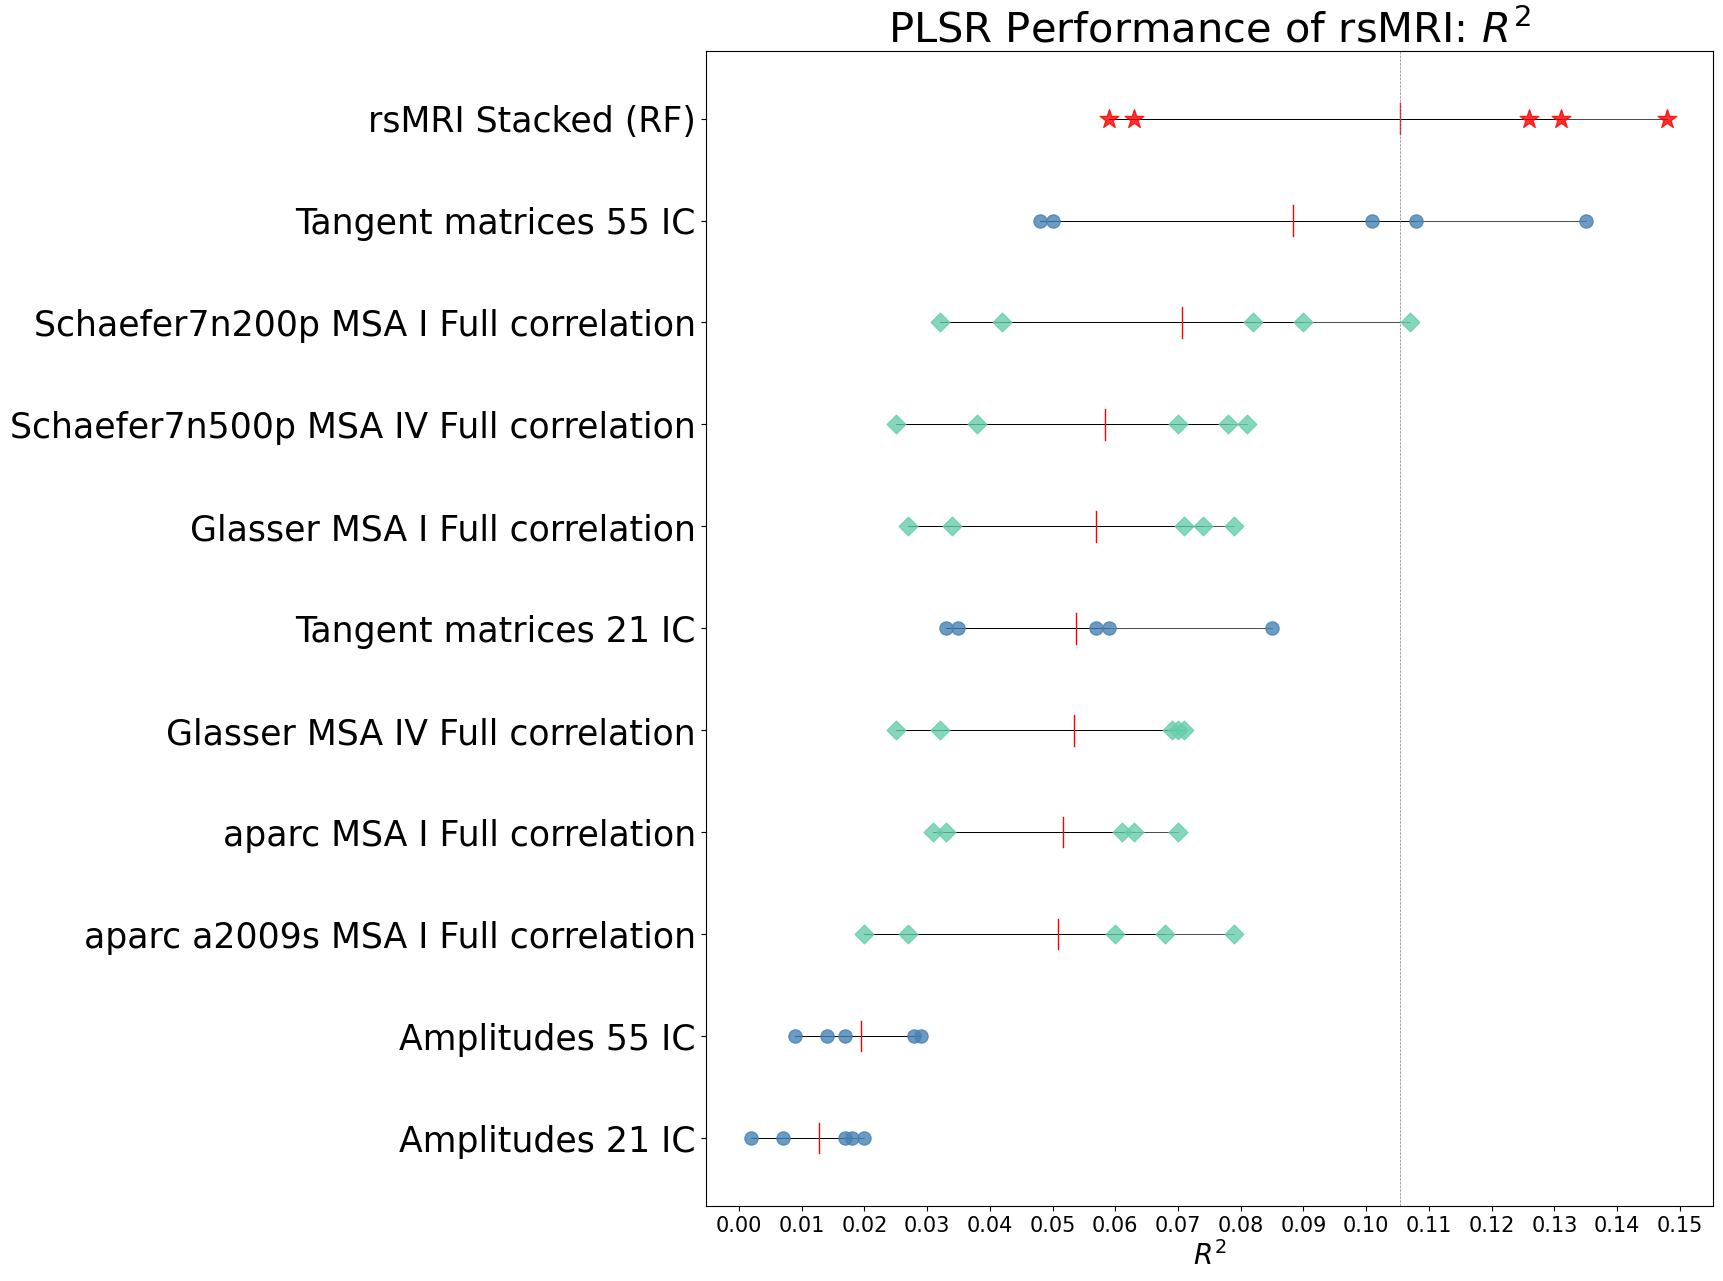

In [135]:
plt.figure(figsize=(13, 15))

# Create an empty plot without boxplot
for i, modality in enumerate(rs_pls_stack_grouped_reindex_r2['Modality']):
    y = [i + 1] * len(rs_pls_stack_plot_r2[rs_pls_stack_plot_r2['Modality'] == modality]['R2'])
    x = rs_pls_stack_plot_r2[rs_pls_stack_plot_r2['Modality'] == modality]['R2']

    if modality in rs_parcellations:
        color = 'mediumaquamarine' #seagreen
        marker='D'
        s=90
    elif modality in rs_idp:
        color = 'steelblue'
        marker= 'o'
        s=90
    else:
        color = 'red'
        marker= '*'
        s=200
        
    plt.scatter(x, y, color=color, marker=marker, s=s, zorder=3,  alpha=0.8)
    plt.plot(x, y, color='black', linewidth=0.5)

    # Calculate the mean across 5 folds and plot a red line
    mean_value = np.mean(rs_pls_stack_plot_r2[rs_pls_stack_plot_r2['Modality'] == modality]['R2'])
    plt.plot([mean_value, mean_value], [i + 0.85, i + 1.15], color='red', linewidth=1)

    if modality == 'rsMRI Stacked (RF)':
        plt.axvline(x=mean_value, color='grey', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.yticks(range(1, len(rs_pls_stack_grouped_reindex_r2['Modality']) + 1), rs_pls_stack_grouped_reindex_r2['Modality'], fontsize = 25)
plt.xticks(fontsize = 15)
plt.xlabel("$R^2$", fontsize = 20)
plt.title("PLSR Performance of rsMRI: $R^2$", fontsize = 30)
plt.show()

# T1w structural + whole-brain T1w/T2w

In [ ]:
# Merge PLS results for T1
folds = ['0', '1', '2', '3', '4']
t1_modalities = ['struct_fast', 'struct_sub_first',
'struct_aseg_mean_intensity', 'struct_aseg_volume',
'struct_ba_exvivo_area',  'struct_ba_exvivo_mean_thickness', 'struct_ba_exvivo_volume',
'struct_a2009s_area', 'struct_a2009s_mean_thickness', 'struct_a2009s_volume',
'struct_dkt_area', 'struct_dkt_mean_thickness', 'struct_dkt_volume',
'struct_desikan_gw', 'struct_desikan_pial', 'struct_desikan_white_area', 'struct_desikan_white_mean_thickness', 'struct_desikan_white_volume',
'struct_subsegmentation']

five_folds_t1 = []
for modality in t1_modalities:
    for fold in folds:
        t1 = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/models/{modality}_fold_{fold}_PLS_result.csv', header=None)
        t1.columns = ['Fold', 'Modality', 'n components', 'MSE', 'MAE', 'R2', 'Pearson r']
        five_folds_t1.append(t1)
        five_folds_t1_struct = pd.concat(five_folds_t1, ignore_index=False)


five_folds_t1_t2_wb = []
for fold in folds:
    t1_t2_wb = pd.read_csv(f'/PLS/brain/additional/fold_{fold}/models/csv/T1_T2_whole_brain_fold_{fold}_PLS_result.csv', header=None)
    t1_t2_wb.columns = ['Fold', 'Modality', 'n components', 'MSE', 'MAE', 'R2', 'Pearson r']
    five_folds_t1_t2_wb.append(t1_t2_wb)
    five_folds_t1_t2_additional = pd.concat(five_folds_t1_t2_wb, ignore_index=False)

t1_t2_pls = pd.concat([five_folds_t1_struct, five_folds_t1_t2_additional], axis=0, ignore_index=True).round(decimals=3)

t1_t2_pls['Pearson r'] = t1_t2_pls['Pearson r'].astype(str).str.replace(r'PearsonRResult\(statistic=|pvalue=|\)', '', regex=True)
t1_t2_pls[['Pearson r', 'p-value']] = t1_t2_pls['Pearson r'].str.split(',', expand=True).astype(float).round(decimals=3)
t1_t2_pls['n components'] = t1_t2_pls['n components'].astype(str).str.replace(r"{'n_components':", '', regex=True)
t1_t2_pls['n components'] = t1_t2_pls['n components'].astype(str).str.replace(r"}", '', regex=True)

t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_fast", 'FSL FAST', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_sub_first", 'FSL FIRST', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_aseg_mean_intensity", 'ASEG mean intensity', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_aseg_volume", 'ASEG volume', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_ba_exvivo_area", 'BA ex-vivo area', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_ba_exvivo_mean_thickness", 'BA ex-vivo mean thickness', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_ba_exvivo_volume", 'BA ex-vivo volume', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_a2009s_area", 'aparc a2009s area', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_a2009s_mean_thickness", 'aparc a2009s mean thickness', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_a2009s_volume", 'aparc a2009s volume', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_dkt_area", 'Desikan-Killiany-Tourville area', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_dkt_mean_thickness", 'Desikan-Killiany-Tourville mean thickness', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_dkt_volume", 'Desikan-Killiany-Tourville volume', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_desikan_gw", 'Desikan grey/white matter intensity', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_desikan_pial", 'Desikan pial', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_desikan_white_area", 'Desikan white matter area', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_desikan_white_mean_thickness", 'Desikan white matter mean thickness', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_desikan_white_volume", 'Desikan white matter volume', regex=True)
t1_t2_pls['Modality'] = t1_t2_pls['Modality'].astype(str).str.replace("struct_subsegmentation", 'Subcortical volumetric subsegmentation', regex=True)
t1_t2_pls

,Fold,Modality,n components,MSE,MAE,R2,Pearson r,p-value
0,0,FSL FAST,5,0.468,0.544,0.065,0.255,0.0
1,1,FSL FAST,3,0.672,0.654,0.024,0.156,0.0
2,2,FSL FAST,2,0.767,0.702,0.018,0.137,0.0
3,3,FSL FAST,5,0.467,0.539,0.078,0.280,0.0
4,4,FSL FAST,8,0.487,0.549,0.070,0.267,0.0
...,...,...,...,...,...,...,...,...
95,0,Whole-brain T1/T2,11,0.443,0.531,0.095,0.309,0.0
96,1,Whole-brain T1/T2,9,0.668,0.653,0.025,0.158,0.0
97,2,Whole-brain T1/T2,11,0.765,0.702,0.016,0.128,0.0
98,3,Whole-brain T1/T2,8,0.477,0.545,0.054,0.232,0.0


In [78]:
# Average across folds
t1_t2_pls_mean = t1_t2_pls[['R2', 'Pearson r', 'Modality', 'MSE', 'MAE']].groupby(['Modality']).mean().round(3).reset_index().sort_values(by="R2", ascending=False)
t1_t2_pls_mean

,Modality,R2,Pearson r,MSE,MAE
15,Subcortical volumetric subsegmentation,0.068,0.244,0.564,0.593
1,ASEG volume,0.059,0.235,0.568,0.595
13,FSL FAST,0.051,0.219,0.572,0.598
16,Whole-brain T1/T2,0.047,0.209,0.567,0.596
0,ASEG mean intensity,0.043,0.199,0.577,0.601
5,Desikan grey/white matter intensity,0.043,0.203,0.576,0.601
19,aparc a2009s volume,0.034,0.180,0.582,0.604
18,aparc a2009s mean thickness,0.027,0.161,0.586,0.606
12,Desikan-Killiany-Tourville volume,0.025,0.157,0.586,0.606
8,Desikan white matter mean thickness,0.024,0.151,0.587,0.607


In [ ]:
# Save result
t1_t2_pls_plot = t1_t2_pls.copy()
t1_t2_pls_plot.to_csv('/PLS/brain/Struct_PLS_Result_five_folds.csv', index=False)
# Group
t1_grouped = t1_t2_pls_plot.groupby('Modality')['Pearson r'].apply(list).reset_index(name='Pearson r values')
t1_grouped

,Modality,Pearson r values
0,ASEG mean intensity,"[0.25, 0.136, 0.117, 0.25, 0.243]"
1,ASEG volume,"[0.273, 0.167, 0.141, 0.306, 0.287]"
2,BA ex-vivo area,"[0.098, 0.044, 0.082, 0.129, 0.092]"
3,BA ex-vivo mean thickness,"[0.165, 0.121, 0.086, 0.151, 0.137]"
4,BA ex-vivo volume,"[0.15, 0.126, 0.103, 0.174, 0.16]"
5,Desikan grey/white matter intensity,"[0.231, 0.149, 0.153, 0.258, 0.223]"
6,Desikan pial,"[0.16, 0.11, 0.101, 0.172, 0.176]"
7,Desikan white matter area,"[0.15, 0.083, 0.112, 0.159, 0.149]"
8,Desikan white matter mean thickness,"[0.18, 0.119, 0.093, 0.189, 0.175]"
9,Desikan white matter volume,"[0.173, 0.128, 0.106, 0.183, 0.169]"


In [80]:
t1_grouped_sort = t1_t2_pls_plot.groupby('Modality')['Pearson r'].mean().reset_index(name='Mean Pearson r values').sort_values(by='Mean Pearson r values', ascending = True)
t1_new_index = t1_grouped_sort.index
t1_grouped_reindex = t1_grouped.reindex(t1_new_index)
t1_grouped_reindex = t1_grouped_reindex.reset_index(drop=True)
t1_grouped_reindex

,Modality,Pearson r values
0,BA ex-vivo area,"[0.098, 0.044, 0.082, 0.129, 0.092]"
1,Desikan white matter area,"[0.15, 0.083, 0.112, 0.159, 0.149]"
2,BA ex-vivo mean thickness,"[0.165, 0.121, 0.086, 0.151, 0.137]"
3,Desikan-Killiany-Tourville area,"[0.147, 0.084, 0.11, 0.161, 0.158]"
4,BA ex-vivo volume,"[0.15, 0.126, 0.103, 0.174, 0.16]"
5,Desikan pial,"[0.16, 0.11, 0.101, 0.172, 0.176]"
6,FSL FIRST,"[0.181, 0.09, 0.083, 0.185, 0.192]"
7,Desikan white matter mean thickness,"[0.18, 0.119, 0.093, 0.189, 0.175]"
8,Desikan white matter volume,"[0.173, 0.128, 0.106, 0.183, 0.169]"
9,Desikan-Killiany-Tourville mean thickness,"[0.179, 0.119, 0.094, 0.19, 0.177]"


In [ ]:
t1_t2_pls_plot.to_csv('/PLS/brain/plot/t1_t2_pls_plot.csv', index=False)
t1_grouped_reindex.to_csv('/PLS/brain/plot/t1_grouped_reindex.csv', index=False)

### Dot/Lineplot

### Add stacked model

In [ ]:
t1t2_pls = pd.read_csv('/PLS/brain/plot/t1_t2_pls_plot.csv')
t1t2_stack = pd.read_csv('/PLS/brain/stacking/T1_T2_whole_brain_stacked_five_folds.csv')
t1t2_stack = t1t2_stack[t1t2_stack['Algorithm'] == 'svr']
t1t2_stack_svr = t1t2_stack[['Fold', 'Pearson r']]
t1t2_stack_svr['Modality'] = 'T1w/T2w Structural Stacked (SVR)'
t1t2_pls_plot = t1t2_pls[['Fold', 'Pearson r', 'Modality']]
t1t2_pls_stack_plot = pd.concat([t1t2_pls_plot, t1t2_stack_svr], axis=0)
t1t2_pls_stack_plot

/tmp/ipykernel_70199/3567821792.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1t2_stack_svr['Modality'] = 'T1w/T2w Structural Stacked (SVR)'


,Fold,Pearson r,Modality
0,0,0.255,FSL FAST
1,1,0.156,FSL FAST
2,2,0.137,FSL FAST
3,3,0.280,FSL FAST
4,4,0.267,FSL FAST
...,...,...,...
15,0,0.361,T1w/T2w Structural Stacked (SVR)
16,1,0.197,T1w/T2w Structural Stacked (SVR)
17,2,0.176,T1w/T2w Structural Stacked (SVR)
18,3,0.360,T1w/T2w Structural Stacked (SVR)


In [13]:
t1t2_pls_stack_grouped = t1t2_pls_stack_plot.groupby('Modality')['Pearson r'].apply(list).reset_index(name='Pearson r values')
t1t2_pls_stack_grouped_sort = t1t2_pls_stack_plot.groupby('Modality')['Pearson r'].mean().reset_index(name='Mean Pearson r values').sort_values(by='Mean Pearson r values', ascending = True)
t1t2_pls_stack_new_index = t1t2_pls_stack_grouped_sort.index
t1t2_pls_stack_grouped_reindex = t1t2_pls_stack_grouped.reindex(t1t2_pls_stack_new_index)
t1t2_pls_stack_grouped_reindex = t1t2_pls_stack_grouped_reindex.reset_index(drop=True)
t1t2_pls_stack_grouped_reindex

,Modality,Pearson r values
0,BA ex-vivo area,"[0.098, 0.044, 0.082, 0.129, 0.092]"
1,Desikan white matter area,"[0.15, 0.083, 0.112, 0.159, 0.149]"
2,Desikan-Killiany-Tourville area,"[0.147, 0.084, 0.11, 0.161, 0.158]"
3,BA ex-vivo mean thickness,"[0.165, 0.121, 0.086, 0.151, 0.137]"
4,BA ex-vivo volume,"[0.15, 0.126, 0.103, 0.174, 0.16]"
5,Desikan pial,"[0.16, 0.11, 0.101, 0.172, 0.176]"
6,FSL FIRST,"[0.181, 0.09, 0.083, 0.185, 0.192]"
7,Desikan white matter mean thickness,"[0.18, 0.119, 0.093, 0.189, 0.175]"
8,Desikan white matter volume,"[0.173, 0.128, 0.106, 0.183, 0.169]"
9,Desikan-Killiany-Tourville mean thickness,"[0.179, 0.119, 0.094, 0.19, 0.177]"


In [ ]:
t1t2_full_r = t1t2_pls_stack_plot.copy()
t1t2_pls_stack_plot.to_csv('/PLS/brain/stacking/t1t2_pls_stack_plot.csv', index=False)
t1t2_full_grouped_reindex_r = t1t2_pls_stack_grouped_reindex.copy()

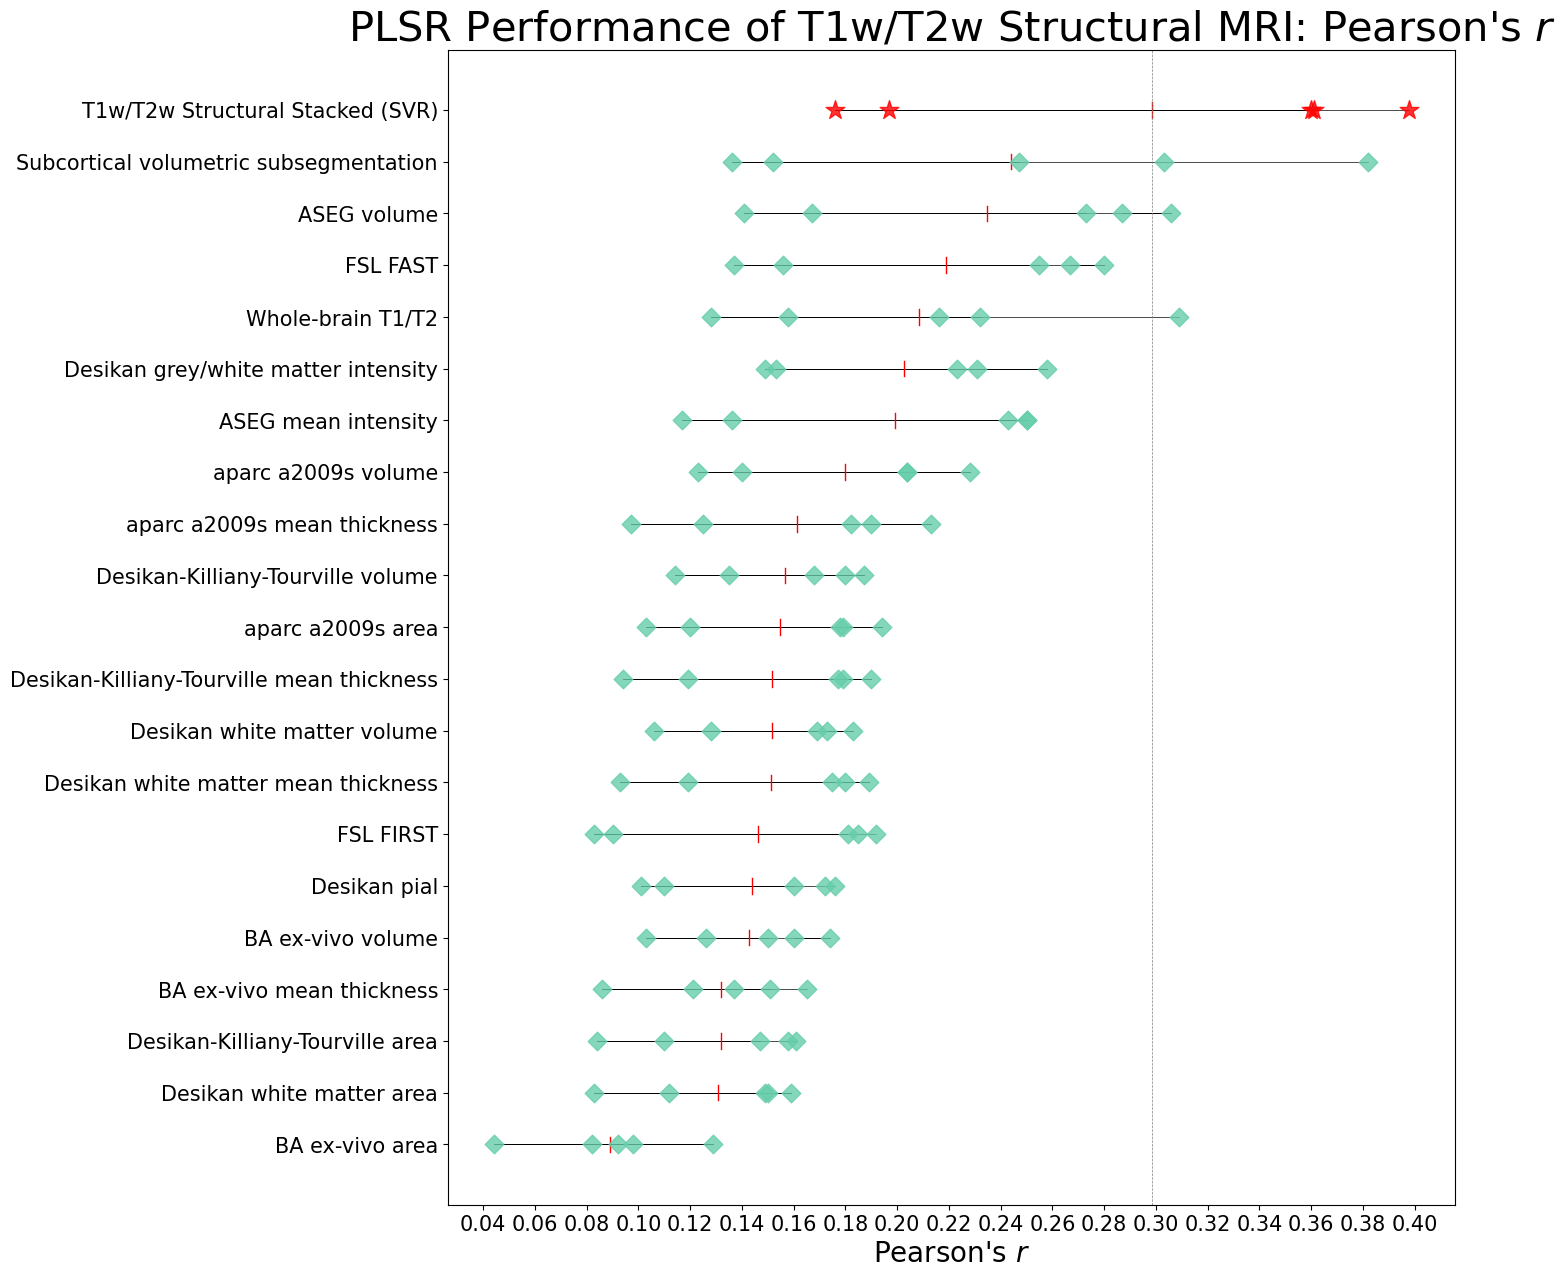

In [127]:
plt.figure(figsize=(13, 15))

# Create an empty plot without boxplot
for i, modality in enumerate(t1t2_pls_stack_grouped_reindex['Modality']):
    y = [i + 1] * len(t1t2_pls_stack_plot[t1t2_pls_stack_plot['Modality'] == modality]['Pearson r'])
    x = t1t2_pls_stack_plot[t1t2_pls_stack_plot['Modality'] == modality]['Pearson r']

    if modality == 'T1w/T2w Structural Stacked (SVR)':
        color = 'red'
        marker= '*'
        s=200
    else:
        color = 'mediumaquamarine' #seagreen
        marker='D'
        s=90

    plt.scatter(x, y, color=color, marker=marker, s=s, zorder=3,  alpha=0.8)
    plt.plot(x, y, color='black', linewidth=0.5)

    # Calculate the mean across 5 folds and plot a red line
    mean_value = np.mean(t1t2_pls_stack_plot[t1t2_pls_stack_plot['Modality'] == modality]['Pearson r'])
    plt.plot([mean_value, mean_value], [i + 0.85, i + 1.15], color='red', linewidth=1)

    if modality == 'T1w/T2w Structural Stacked (SVR)':
        plt.axvline(x=mean_value, color='grey', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.02))
plt.yticks(range(1, len(t1t2_pls_stack_grouped_reindex['Modality']) + 1), t1t2_pls_stack_grouped_reindex['Modality'], fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel("Pearson's $r$", fontsize = 20)
plt.title("PLSR Performance of T1w/T2w Structural MRI: Pearson's $r$", fontsize = 30)
plt.show()

### Do all the same for R2

In [ ]:
t1t2_pls = pd.read_csv('/PLS/brain/plot/t1_t2_pls_plot.csv')
t1t2_stack = pd.read_csv('/PLS/brain/stacking/T1_T2_whole_brain_stacked_five_folds.csv')
t1t2_stack = t1t2_stack[t1t2_stack['Algorithm'] == 'svr']
t1t2_stack_svr = t1t2_stack[['Fold', 'Pearson r']]
t1t2_stack_svr['Modality'] = 'T1w/T2w Structural Stacked (SVR)'
t1t2_pls_plot = t1t2_pls[['Fold', 'Pearson r', 'Modality']]
t1t2_pls_stack_plot = pd.concat([t1t2_pls_plot, t1t2_stack_svr], axis=0)
t1t2_pls_stack_plot

/tmp/ipykernel_70199/3567821792.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1t2_stack_svr['Modality'] = 'T1w/T2w Structural Stacked (SVR)'


,Fold,Pearson r,Modality
0,0,0.255,FSL FAST
1,1,0.156,FSL FAST
2,2,0.137,FSL FAST
3,3,0.280,FSL FAST
4,4,0.267,FSL FAST
...,...,...,...
15,0,0.361,T1w/T2w Structural Stacked (SVR)
16,1,0.197,T1w/T2w Structural Stacked (SVR)
17,2,0.176,T1w/T2w Structural Stacked (SVR)
18,3,0.360,T1w/T2w Structural Stacked (SVR)


In [118]:
t1t2_stack_svr = t1t2_stack[['Fold', 'R2']]
t1t2_stack_svr['Modality'] = 'T1w/T2w Structural Stacked (SVR)'
t1t2_pls_plot = t1t2_pls[['Fold', 'R2', 'Modality']]
t1t2_pls_stack_plot_r2 = pd.concat([t1t2_pls_plot, t1t2_stack_svr], axis=0)

t1t2_pls_stack_grouped = t1t2_pls_stack_plot_r2.groupby('Modality')['R2'].apply(list).reset_index(name='R2 values')
t1t2_pls_stack_grouped_sort = t1t2_pls_stack_plot_r2.groupby('Modality')['R2'].mean().reset_index(name='Mean R2 values').sort_values(by='Mean R2 values', ascending = True)
t1t2_pls_stack_new_index = t1t2_pls_stack_grouped_sort.index
t1t2_pls_stack_grouped_reindex_r2 = t1t2_pls_stack_grouped.reindex(t1t2_pls_stack_new_index)
t1t2_pls_stack_grouped_reindex_r2 = t1t2_pls_stack_grouped_reindex_r2.reset_index(drop=True)
t1t2_pls_stack_grouped_reindex_r2

/tmp/ipykernel_70199/4245475591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1t2_stack_svr['Modality'] = 'T1w/T2w Structural Stacked (SVR)'


,Modality,R2 values
0,BA ex-vivo area,"[0.009, 0.0, 0.007, 0.016, 0.007]"
1,Desikan white matter area,"[0.022, 0.006, 0.012, 0.025, 0.021]"
2,BA ex-vivo mean thickness,"[0.027, 0.014, 0.007, 0.022, 0.018]"
3,Desikan-Killiany-Tourville area,"[0.021, 0.006, 0.012, 0.026, 0.024]"
4,BA ex-vivo volume,"[0.022, 0.016, 0.011, 0.03, 0.025]"
5,Desikan pial,"[0.025, 0.012, 0.01, 0.029, 0.03]"
6,FSL FIRST,"[0.032, 0.008, 0.006, 0.034, 0.036]"
7,Desikan white matter volume,"[0.029, 0.016, 0.011, 0.033, 0.028]"
8,Desikan white matter mean thickness,"[0.032, 0.014, 0.008, 0.035, 0.029]"
9,Desikan-Killiany-Tourville mean thickness,"[0.031, 0.014, 0.008, 0.036, 0.03]"


In [ ]:
t1t2_pls_stack_plot_r2.to_csv('/PLS/brain/stacking/t1t2_pls_stack_plot_r2.csv', index=False)
t1t2_full_r2 = t1t2_pls_stack_plot_r2.copy()
t1t2_full_grouped_reindex_r2 = t1t2_pls_stack_grouped_reindex_r2.copy()

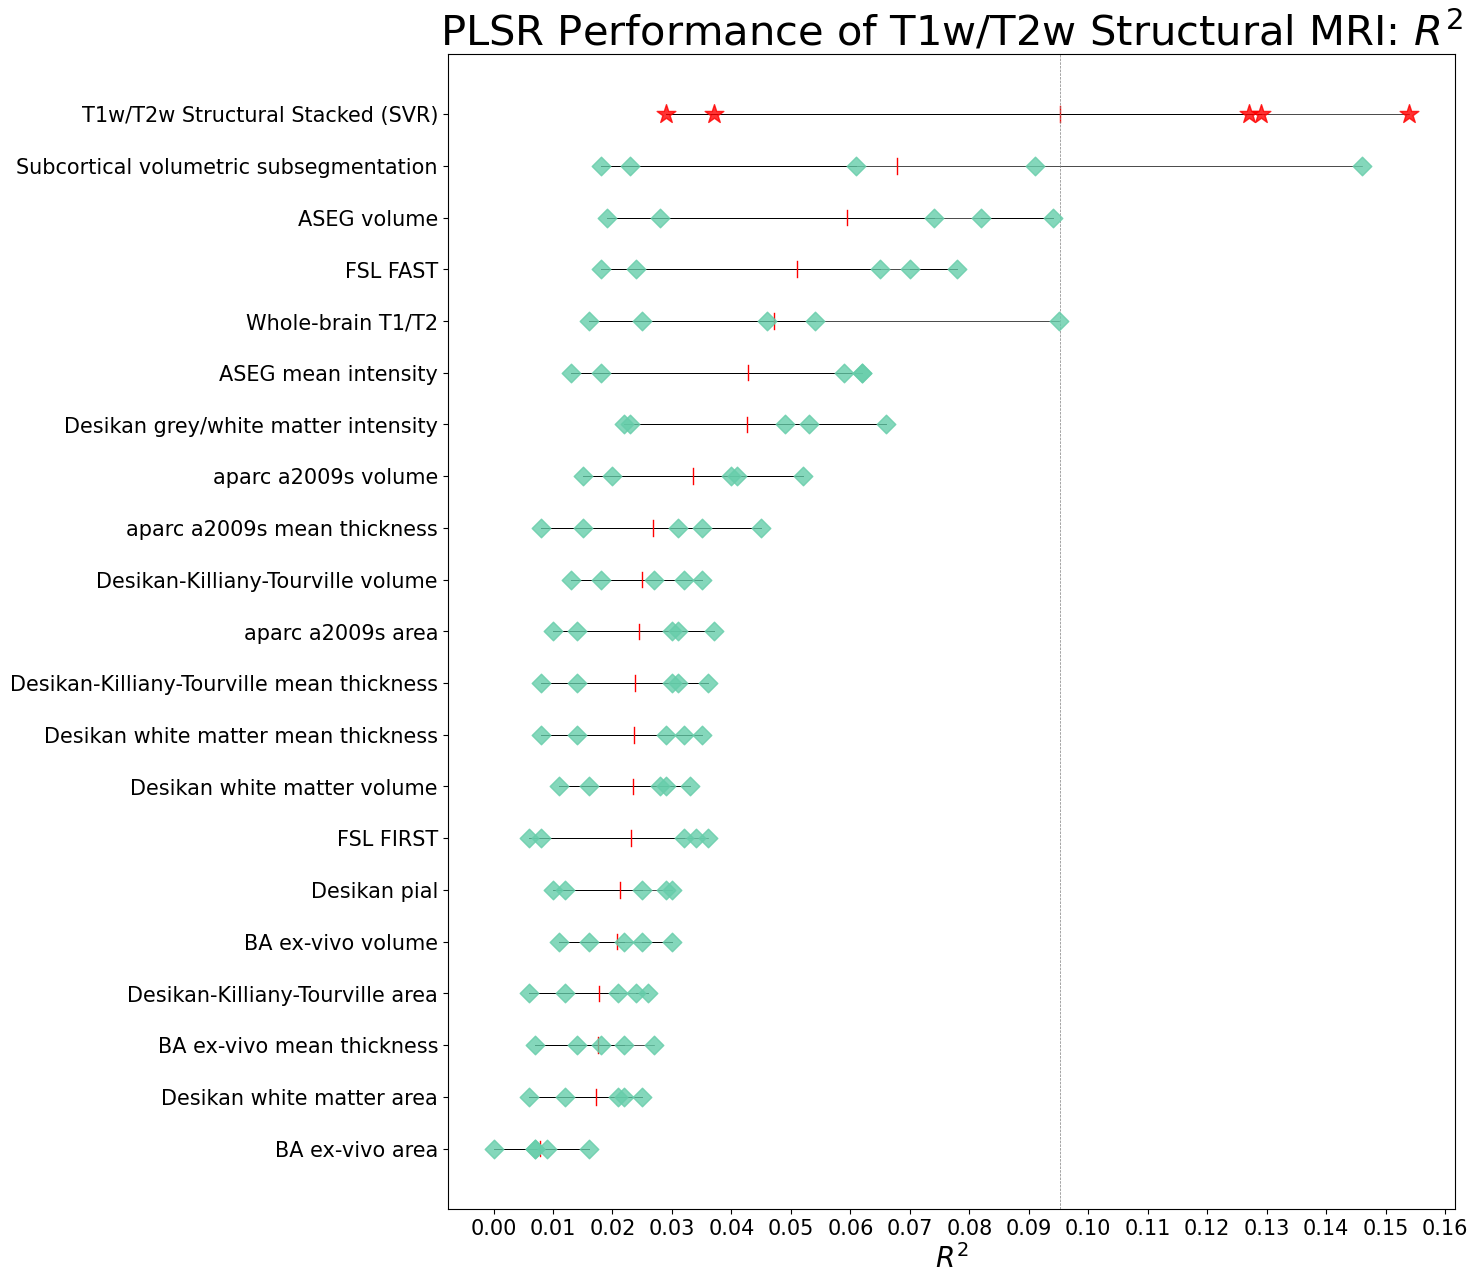

In [123]:
plt.figure(figsize=(13, 15))

# Create an empty plot without boxplot
for i, modality in enumerate(t1t2_pls_stack_grouped_reindex_r2['Modality']):
    y = [i + 1] * len(t1t2_pls_stack_plot_r2[t1t2_pls_stack_plot_r2['Modality'] == modality]['R2'])
    x = t1t2_pls_stack_plot_r2[t1t2_pls_stack_plot_r2['Modality'] == modality]['R2']

    if modality == 'T1w/T2w Structural Stacked (SVR)':
        color = 'red'
        marker= '*'
        s=200
    else:
        color = 'mediumaquamarine' #seagreen
        marker='D'
        s=90
        
    plt.scatter(x, y, color=color, marker=marker, s=s, zorder=3,  alpha=0.8)
    plt.plot(x, y, color='black', linewidth=0.5)

    # Calculate the mean across 5 folds and plot a red line
    mean_value = np.mean(t1t2_pls_stack_plot_r2[t1t2_pls_stack_plot_r2['Modality'] == modality]['R2'])
    plt.plot([mean_value, mean_value], [i + 0.85, i + 1.15], color='red', linewidth=1)

    if modality == 'T1w/T2w Structural Stacked (SVR)':
        plt.axvline(x=mean_value, color='grey', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.yticks(range(1, len(t1t2_pls_stack_grouped_reindex_r2['Modality']) + 1), t1t2_pls_stack_grouped_reindex_r2['Modality'], fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel("$R^2$", fontsize = 20)
plt.title("PLSR Performance of T1w/T2w Structural MRI: $R^2$", fontsize = 30)
plt.show()

# Plot all modalities

In [156]:
all_pls = pd.concat([t1_t2_pls_plot, dti_pls_plot, rs_pls_plot], axis=0, ignore_index=True)
all_pls

,Fold,Modality,n components,MSE,MAE,R2,Pearson r,p-value
0,0,FSL FAST,5,0.468,0.544,0.065,0.255,0.0
1,1,FSL FAST,3,0.672,0.654,0.024,0.156,0.0
2,2,FSL FAST,2,0.767,0.702,0.018,0.137,0.0
3,3,FSL FAST,5,0.467,0.539,0.078,0.280,0.0
4,4,FSL FAST,8,0.487,0.549,0.070,0.267,0.0
...,...,...,...,...,...,...,...,...
355,0,Tangent matrices 55 IC,3,0.435,0.528,0.135,0.369,0.0
356,1,Tangent matrices 55 IC,3,0.655,0.645,0.050,0.242,0.0
357,2,Tangent matrices 55 IC,3,0.743,0.687,0.048,0.237,0.0
358,3,Tangent matrices 55 IC,3,0.458,0.536,0.101,0.327,0.0


In [157]:
all_grouped = all_pls.groupby('Modality')['Pearson r'].apply(list).reset_index(name='Pearson r values')
all_grouped

,Modality,Pearson r values
0,ASEG mean intensity,"[0.25, 0.136, 0.117, 0.25, 0.243]"
1,ASEG volume,"[0.273, 0.167, 0.141, 0.306, 0.287]"
2,Amplitudes 21 IC,"[0.141, 0.065, 0.085, 0.132, 0.138]"
3,Amplitudes 55 IC,"[0.169, 0.1, 0.121, 0.172, 0.136]"
4,BA ex-vivo Area,"[0.098, 0.044, 0.082, 0.129, 0.092]"
...,...,...
67,aparc a2009s MSA I Connectome Streamline Count,"[0.278, 0.167, 0.142, 0.291, 0.258]"
68,aparc a2009s MSA I Full correlation,"[0.29, 0.187, 0.157, 0.273, 0.26]"
69,aparc a2009s area,"[0.179, 0.103, 0.12, 0.194, 0.178]"
70,aparc a2009s mean thickness,"[0.19, 0.125, 0.097, 0.213, 0.182]"


In [158]:
all_grouped_sort = all_pls.groupby('Modality')['Pearson r'].mean().reset_index(name='Mean Pearson r values').sort_values(by='Mean Pearson r values', ascending = True)
all_new_index = all_grouped_sort.index
all_grouped_reindex = all_grouped.reindex(all_new_index)
all_grouped_reindex = all_grouped_reindex.reset_index(drop=True)
all_grouped_reindex

,Modality,Pearson r values
0,MO Probabilistic,"[0.086, 0.046, 0.034, 0.102, 0.111]"
1,BA ex-vivo Area,"[0.098, 0.044, 0.082, 0.129, 0.092]"
2,OD Probabilistic,"[0.115, 0.064, 0.061, 0.125, 0.129]"
3,Amplitudes 21 IC,"[0.141, 0.065, 0.085, 0.132, 0.138]"
4,Desikan white matter area,"[0.15, 0.083, 0.112, 0.159, 0.149]"
...,...,...
67,Subcortical volumetric subsegmentation,"[0.247, 0.152, 0.136, 0.303, 0.382]"
68,Glasser MSA I Full correlation,"[0.295, 0.201, 0.184, 0.29, 0.273]"
69,Schaefer7n500p MSA IV Full correlation,"[0.295, 0.21, 0.186, 0.294, 0.277]"
70,Schaefer7n200p MSA I Full correlation,"[0.335, 0.216, 0.195, 0.299, 0.311]"


In [ ]:
all_pls.to_csv('/PLS/brain/plot/all_pls.csv', index=False)
all_grouped_reindex.to_csv('/PLS/brain/plot/all_pls.csv', index=False)

In [159]:
dti_struct = [
'aparc MSA I Connectome Streamline Count',
'aparc MSA I Connectome SIFT2',
'aparc a2009s MSA I Connectome Streamline Count',
'Schaefer7n200p MSA I Connectome Streamline Count',
'Schaefer7n200p MSA I Connectome SIFT2',
'aparc MSA I Connectome FA',
'aparc a2009s MSA I Connectome FA',
'aparc MSA I Connectome Mean Length',
'aparc a2009s MSA I Connectome SIFT2',
'Schaefer7n200p MSA I Connectome FA',
'aparc a2009s MSA I Connectome Mean Length',
'Glasser MSA IV Connectome SIFT2',
'Glasser MSA IV Connectome Streamline Count',
'Glasser MSA IV Connectome FA',
'Schaefer7n500p MSA IV Connectome SIFT2',
'Schaefer7n500p MSA IV Connectome Streamline Count',
'Glasser MSA I Connectome FA',
'Schaefer7n200p MSA I Connectome Mean Length',
'Glasser MSA I Connectome Streamline Count',
'Schaefer7n500p MSA IV Connectome FA',
'Glasser MSA I Connectome SIFT2',
'Glasser MSA IV Connectome Mean Length',
'Glasser MSA I Connectome Mean Length',
'Schaefer7n500p MSA IV Connectome Mean Length'
]

dti_idp = [
'OD Probabilistic',
'MO Probabilistic',
'OD TBSS',
'ICVF Probabilistic',
'MO TBSS',
'ISOVF Probabilistic',
'FA Probabilistic',
'L2 Probabilistic',
'L1 Probabilistic',
'ISOVF TBSS',
'L3 Probabilistic',
'MD TBSS',
'MD Probabilistic',
'L2 TBSS',
'L3 TBSS',
'ICVF TBSS',
'L1 TBSS',
'FA TBSS'
]

rs_parcellations = [
'aparc MSA I Full correlation',
'aparc a2009s MSA I Full correlation',
'Glasser MSA I Full correlation',
'Glasser MSA IV Full correlation',
'Schaefer7n200p MSA I Full correlation',
'Schaefer7n500p MSA IV Full correlation'
]

rs_idp = [
'Amplitudes 21 IC',
'Amplitudes 55 IC',
'Tangent matrices 21 IC',
'Tangent matrices 55 IC'
]

In [1]:
# Define modalities: after renaming
rs_parcellations = ['aparc-I Functional Connectivity',
       'aparc.a2009s-I Functional Connectivity',
       'Glasser-I Functional Connectivity',
       'Glasser-IV Functional Connectivity',
       'Schaefer200-I Functional Connectivity',
       'Schaefer500-IV Functional Connectivity']
       
rs_idp = ['55 IC Amplitudes','21 IC Amplitudes', '21 IC Functional Connectivity','55 IC Functional Connectivity']    

dti_parcellations = ['aparc.a2009s-I FA',
       'aparc.a2009s-I Mean Length', 'aparc.a2009s-I SIFT2',
       'aparc.a2009s-I Streamline Count', 'aparc-I FA', 'aparc-I Mean Length',
       'aparc-I SIFT2', 'aparc-I Streamline Count', 'Glasser-I FA',
       'Glasser-I Mean Length', 'Glasser-I SIFT2',
       'Glasser-I Streamline Count', 'Glasser-IV FA', 'Glasser-IV Mean Length',
       'Glasser-IV SIFT2', 'Glasser-IV Streamline Count', 'Schaefer200-I FA',
       'Schaefer200-I Mean Length', 'Schaefer200-I SIFT2',
       'Schaefer200-I Streamline Count', 'Schaefer500-IV FA',
       'Schaefer500-IV Mean Length', 'Schaefer500-IV SIFT2',
       'Schaefer500-IV Streamline Count']
dti_idp = ['FA TBSS', 'FA Prob.', 'MD TBSS', 'MD Prob.',
       'L1 TBSS', 'L1 Prob.', 'L2 TBSS', 'L2 Prob.', 'L3 TBSS', 'L3 Prob.',
       'MO TBSS', 'MO Prob.', 'OD TBSS', 'OD Prob.', 'ICVF TBSS', 'ICVF Prob.',
       'ISOVF TBSS', 'ISOVF Prob.']
t1t2_modalities = ['FSL FAST', 'FSL FIRST',
       'ASEG Mean Thickness', 'ASEG Volume', 'BA ex-vivo Area',
       'BA ex-vivo Mean Thickness', 'BA ex-vivo Volume', 'aparc.a2009s Area',
       'aparc.a2009s Mean Thickness', 'aparc.a2009s Volume', 'DKT Area',
       'DKT Mean Thickness', 'DKT Volume', 'Desikan GM/WM Intensity',
       'Desikan Pial', 'Desikan WM Area', 'Desikan WM Mean Thickness',
       'Desikan WM Volume', 'Subcor. Volumetric Subsegment.',
       'Whole-brain T1/T2']

# All modalities + Stacked

In [282]:
# Define modalities
dti_struct = [
'aparc MSA I Connectome Streamline Count',
'aparc MSA I Connectome SIFT2',
'aparc a2009s MSA I Connectome Streamline Count',
'Schaefer7n200p MSA I Connectome Streamline Count',
'Schaefer7n200p MSA I Connectome SIFT2',
'aparc MSA I Connectome FA',
'aparc a2009s MSA I Connectome FA',
'aparc MSA I Connectome Mean Length',
'aparc a2009s MSA I Connectome SIFT2',
'Schaefer7n200p MSA I Connectome FA',
'aparc a2009s MSA I Connectome Mean Length',
'Glasser MSA IV Connectome SIFT2',
'Glasser MSA IV Connectome Streamline Count',
'Glasser MSA IV Connectome FA',
'Schaefer7n500p MSA IV Connectome SIFT2',
'Schaefer7n500p MSA IV Connectome Streamline Count',
'Glasser MSA I Connectome FA',
'Schaefer7n200p MSA I Connectome Mean Length',
'Glasser MSA I Connectome Streamline Count',
'Schaefer7n500p MSA IV Connectome FA',
'Glasser MSA I Connectome SIFT2',
'Glasser MSA IV Connectome Mean Length',
'Glasser MSA I Connectome Mean Length',
'Schaefer7n500p MSA IV Connectome Mean Length'
]

dti_idp = [
'OD Probabilistic',
'MO Probabilistic',
'OD TBSS',
'ICVF Probabilistic',
'MO TBSS',
'ISOVF Probabilistic',
'FA Probabilistic',
'L2 Probabilistic',
'L1 Probabilistic',
'ISOVF TBSS',
'L3 Probabilistic',
'MD TBSS',
'MD Probabilistic',
'L2 TBSS',
'L3 TBSS',
'ICVF TBSS',
'L1 TBSS',
'FA TBSS'
]

rs_parcellations = [
'aparc MSA I Full correlation',
'aparc a2009s MSA I Full correlation',
'Glasser MSA I Full correlation',
'Glasser MSA IV Full correlation',
'Schaefer7n200p MSA I Full correlation',
'Schaefer7n500p MSA IV Full correlation'
]

rs_idp = [
'Amplitudes 21 IC',
'Amplitudes 55 IC',
'Tangent matrices 21 IC',
'Tangent matrices 55 IC'
]

modalities_struct = ['FSL FAST', 'FSL FIRST', 'ASEG mean intensity', 'ASEG volume',
       'BA ex-vivo area', 'BA ex-vivo mean thickness',
       'BA ex-vivo volume', 'aparc a2009s area',
       'aparc a2009s mean thickness', 'aparc a2009s volume',
       'Desikan-Killiany-Tourville area',
       'Desikan-Killiany-Tourville mean thickness',
       'Desikan-Killiany-Tourville volume',
       'Desikan grey/white matter intensity', 'Desikan pial',
       'Desikan white matter area', 'Desikan white matter mean thickness',
       'Desikan white matter volume',
       'Subcortical volumetric subsegmentation', 'Whole-brain T1/T2']

In [69]:
# Define modalities: after renaming
rs_parcellations = ['aparc-I Functional Connectivity',
       'aparc.a2009s-I Functional Connectivity',
       'Glasser-I Functional Connectivity',
       'Glasser-IV Functional Connectivity',
       'Schaefer200-I Functional Connectivity',
       'Schaefer500-IV Functional Connectivity']
       
rs_idp = ['55 IC Amplitudes','21 IC Amplitudes', '21 IC Functional Connectivity','55 IC Functional Connectivity']    

dti_parcellations = ['aparc.a2009s-I FA',
       'aparc.a2009s-I Mean Length', 'aparc.a2009s-I SIFT2',
       'aparc.a2009s-I Streamline Count', 'aparc-I FA', 'aparc-I Mean Length',
       'aparc-I SIFT2', 'aparc-I Streamline Count', 'Glasser-I FA',
       'Glasser-I Mean Length', 'Glasser-I SIFT2',
       'Glasser-I Streamline Count', 'Glasser-IV FA', 'Glasser-IV Mean Length',
       'Glasser-IV SIFT2', 'Glasser-IV Streamline Count', 'Schaefer200-I FA',
       'Schaefer200-I Mean Length', 'Schaefer200-I SIFT2',
       'Schaefer200-I Streamline Count', 'Schaefer500-IV FA',
       'Schaefer500-IV Mean Length', 'Schaefer500-IV SIFT2',
       'Schaefer500-IV Streamline Count']
dti_idp = ['FA TBSS', 'FA Prob.', 'MD TBSS', 'MD Prob.',
       'L1 TBSS', 'L1 Prob.', 'L2 TBSS', 'L2 Prob.', 'L3 TBSS', 'L3 Prob.',
       'MO TBSS', 'MO Prob.', 'OD TBSS', 'OD Prob.', 'ICVF TBSS', 'ICVF Prob.',
       'ISOVF TBSS', 'ISOVF Prob.']
t1t2_modalities = ['FSL FAST', 'FSL FIRST',
       'ASEG Mean Thickness', 'ASEG Volume', 'BA ex-vivo Area',
       'BA ex-vivo Mean Thickness', 'BA ex-vivo Volume', 'aparc.a2009s Area',
       'aparc.a2009s Mean Thickness', 'aparc.a2009s Volume', 'DKT Area',
       'DKT Mean Thickness', 'DKT Volume', 'Desikan GM/WM Intensity',
       'Desikan Pial', 'Desikan WM Area', 'Desikan WM Mean Thickness',
       'Desikan WM Volume', 'Subcor. Volumetric Subsegment.',
       'Whole-brain T1/T2']

### Pearson r

In [ ]:
all_stack = pd.read_csv('/PLS/brain/stacking/All_modalities_stacked_five_folds.csv')
all_stack = all_stack[all_stack['Algorithm'] == 'xgb']
all_stack_xgb_r = all_stack[['Fold', 'Pearson r']]
all_stack_xgb_r['Modality'] = 'All MRI Modalities Stacked (XGB)'
all_stack_xgb_r

/tmp/ipykernel_70199/3031166111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_stack_xgb_r['Modality'] = 'All MRI Modalities Stacked (XGB)'


,Fold,Pearson r,Modality
5,0,0.475,All MRI Modalities Stacked (XGB)
6,1,0.295,All MRI Modalities Stacked (XGB)
7,2,0.274,All MRI Modalities Stacked (XGB)
8,3,0.452,All MRI Modalities Stacked (XGB)
9,4,0.492,All MRI Modalities Stacked (XGB)


In [ ]:
all_modalities_plus_stacked_plot_r = pd.concat([dti_full_r, rs_full_r, t1t2_full_r, all_stack_xgb_r], axis = 0)
all_modalities_plus_stacked_plot_r.to_csv('/PLS/brain/stacking/all_modalities_plus_stacked_plot_r.csv', index=False)

In [ ]:
all_modalities_plus_stacked_plot_r = pd.read_csv('/PLS/brain/stacking/all_modalities_plus_stacked_plot_r.csv')
all_modalities_plus_stacked_plot_r

,Fold,Pearson r,Modality
0,0,0.229,FA TBSS
1,1,0.120,FA TBSS
2,2,0.149,FA TBSS
3,3,0.250,FA TBSS
4,4,0.244,FA TBSS
...,...,...,...
375,0,0.475,All MRI Modalities Stacked (XGB)
376,1,0.295,All MRI Modalities Stacked (XGB)
377,2,0.274,All MRI Modalities Stacked (XGB)
378,3,0.452,All MRI Modalities Stacked (XGB)


In [81]:
# Rename modalities for plotting
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].astype(str).str.replace('aparc MSA I Full correlation', 'aparc-I Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('aparc a2009s MSA I Full correlation', 'aparc.a2009s-I Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Glasser MSA I Full correlation', 'Glasser-I Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Glasser MSA IV Full correlation', 'Glasser-IV Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Schaefer7n200p MSA I Full correlation', 'Schaefer200-I Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Schaefer7n500p MSA IV Full correlation', 'Schaefer500-IV Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Amplitudes 21 IC', '55 IC Amplitudes', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Amplitudes 55 IC', '21 IC Amplitudes', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Tangent matrices 21 IC', '21 IC Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Tangent matrices 55 IC', '55 IC Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('aparc a2009s MSA I Connectome FA', 'aparc.a2009s-I FA', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('aparc a2009s MSA I Connectome Mean Length', 'aparc.a2009s-I Mean Length', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('aparc a2009s MSA I Connectome SIFT2', 'aparc.a2009s-I SIFT2', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('aparc a2009s MSA I Connectome Streamline Count', 'aparc.a2009s-I Streamline Count', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('aparc MSA I Connectome FA', 'aparc-I FA', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('aparc MSA I Connectome Mean Length', 'aparc-I Mean Length', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('aparc MSA I Connectome SIFT2', 'aparc-I SIFT2', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('aparc MSA I Connectome Streamline Count', 'aparc-I Streamline Count', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Glasser MSA I Connectome FA', 'Glasser-I FA', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Glasser MSA I Connectome Mean Length', 'Glasser-I Mean Length', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Glasser MSA I Connectome SIFT2', 'Glasser-I SIFT2', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Glasser MSA I Connectome Streamline Count', 'Glasser-I Streamline Count', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Glasser MSA IV Connectome FA', 'Glasser-IV FA', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Glasser MSA IV Connectome Mean Length', 'Glasser-IV Mean Length', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Glasser MSA IV Connectome SIFT2', 'Glasser-IV SIFT2', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Glasser MSA IV Connectome Streamline Count', 'Glasser-IV Streamline Count', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Schaefer7n200p MSA I Connectome FA', 'Schaefer200-I FA', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Schaefer7n200p MSA I Connectome Mean Length', 'Schaefer200-I Mean Length', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Schaefer7n200p MSA I Connectome SIFT2', 'Schaefer200-I SIFT2', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Schaefer7n200p MSA I Connectome Streamline Count', 'Schaefer200-I Streamline Count', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Schaefer7n500p MSA IV Connectome FA', 'Schaefer500-IV FA', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Schaefer7n500p MSA IV Connectome Mean Length', 'Schaefer500-IV Mean Length', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Schaefer7n500p MSA IV Connectome SIFT2', 'Schaefer500-IV SIFT2', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Schaefer7n500p MSA IV Connectome Streamline Count', 'Schaefer500-IV Streamline Count', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('FA Probabilistic', 'FA Prob.', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('MD Probabilistic', 'MD Prob.', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('L1 Probabilistic', 'L1 Prob.', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('L2 Probabilistic', 'L2 Prob.', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('L3 Probabilistic', 'L3 Prob.', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('MO Probabilistic', 'MO Prob.', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('OD Probabilistic', 'OD Prob.', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('ICVF Probabilistic', 'ICVF Prob.', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('ISOVF Probabilistic', 'ISOVF Prob.', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('aparc a2009s Area', 'aparc.a2009s Area', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('aparc a2009s Mean Thickness', 'aparc.a2009s Mean Thickness', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('aparc a2009s volume', 'aparc.a2009s Volume', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Desikan-Killiany-Tourville Area', 'DKT Area', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Desikan-Killiany-Tourville Mean Thickness', 'DKT Mean Thickness', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Desikan-Killiany-Tourville volume', 'DKT Volume', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Desikan Grey/White Matter intensity', 'Desikan GM/WM Intensity', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Desikan pial', 'Desikan Pial', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Desikan White Matter Area', 'Desikan WM Area', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Desikan White Matter Mean Thickness', 'Desikan WM Mean Thickness', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Desikan White Matter volume', 'Desikan WM Volume', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('Subcortical Volumetric Subsegmentation', 'Subcor. Volumetric Subsegment.', regex=True)
all_modalities_plus_stacked_plot_r['Modality'] = all_modalities_plus_stacked_plot_r['Modality'].str.replace('ASEG volume', 'ASEG Volume', regex=True)

In [82]:
# Arrange values for plotting
all_modalities_plus_stacked_plot_r_grouped = all_modalities_plus_stacked_plot_r.groupby('Modality')['Pearson r'].apply(list).reset_index(name='Pearson r values')
all_modalities_plus_stacked_plot_r_grouped_sort = all_modalities_plus_stacked_plot_r.groupby('Modality')['Pearson r'].mean().reset_index(name='Mean Pearson r values').sort_values(by='Mean Pearson r values', ascending = True)
all_modalities_plus_stacked_plot_r_new_index = all_modalities_plus_stacked_plot_r_grouped_sort.index
all_modalities_plus_stacked_grouped_reindex_r = all_modalities_plus_stacked_plot_r_grouped.reindex(all_modalities_plus_stacked_plot_r_new_index)
all_modalities_plus_stacked_grouped_reindex_r = all_modalities_plus_stacked_grouped_reindex_r.reset_index(drop=True)
all_modalities_plus_stacked_grouped_reindex_r

,Modality,Pearson r values
0,MO Prob.,"[0.086, 0.046, 0.034, 0.102, 0.111]"
1,BA ex-vivo area,"[0.098, 0.044, 0.082, 0.129, 0.092]"
2,OD Prob.,"[0.115, 0.064, 0.061, 0.125, 0.129]"
3,55 IC Amplitudes,"[0.141, 0.065, 0.085, 0.132, 0.138]"
4,Desikan white matter area,"[0.15, 0.083, 0.112, 0.159, 0.149]"
...,...,...
71,Schaefer200-I Functional Connectivity,"[0.335, 0.216, 0.195, 0.299, 0.311]"
72,T1w/T2w Structural Stacked (SVR),"[0.361, 0.197, 0.176, 0.36, 0.398]"
73,55 IC Functional Connectivity,"[0.369, 0.242, 0.237, 0.327, 0.333]"
74,rsMRI Stacked (RF),"[0.387, 0.262, 0.252, 0.366, 0.359]"


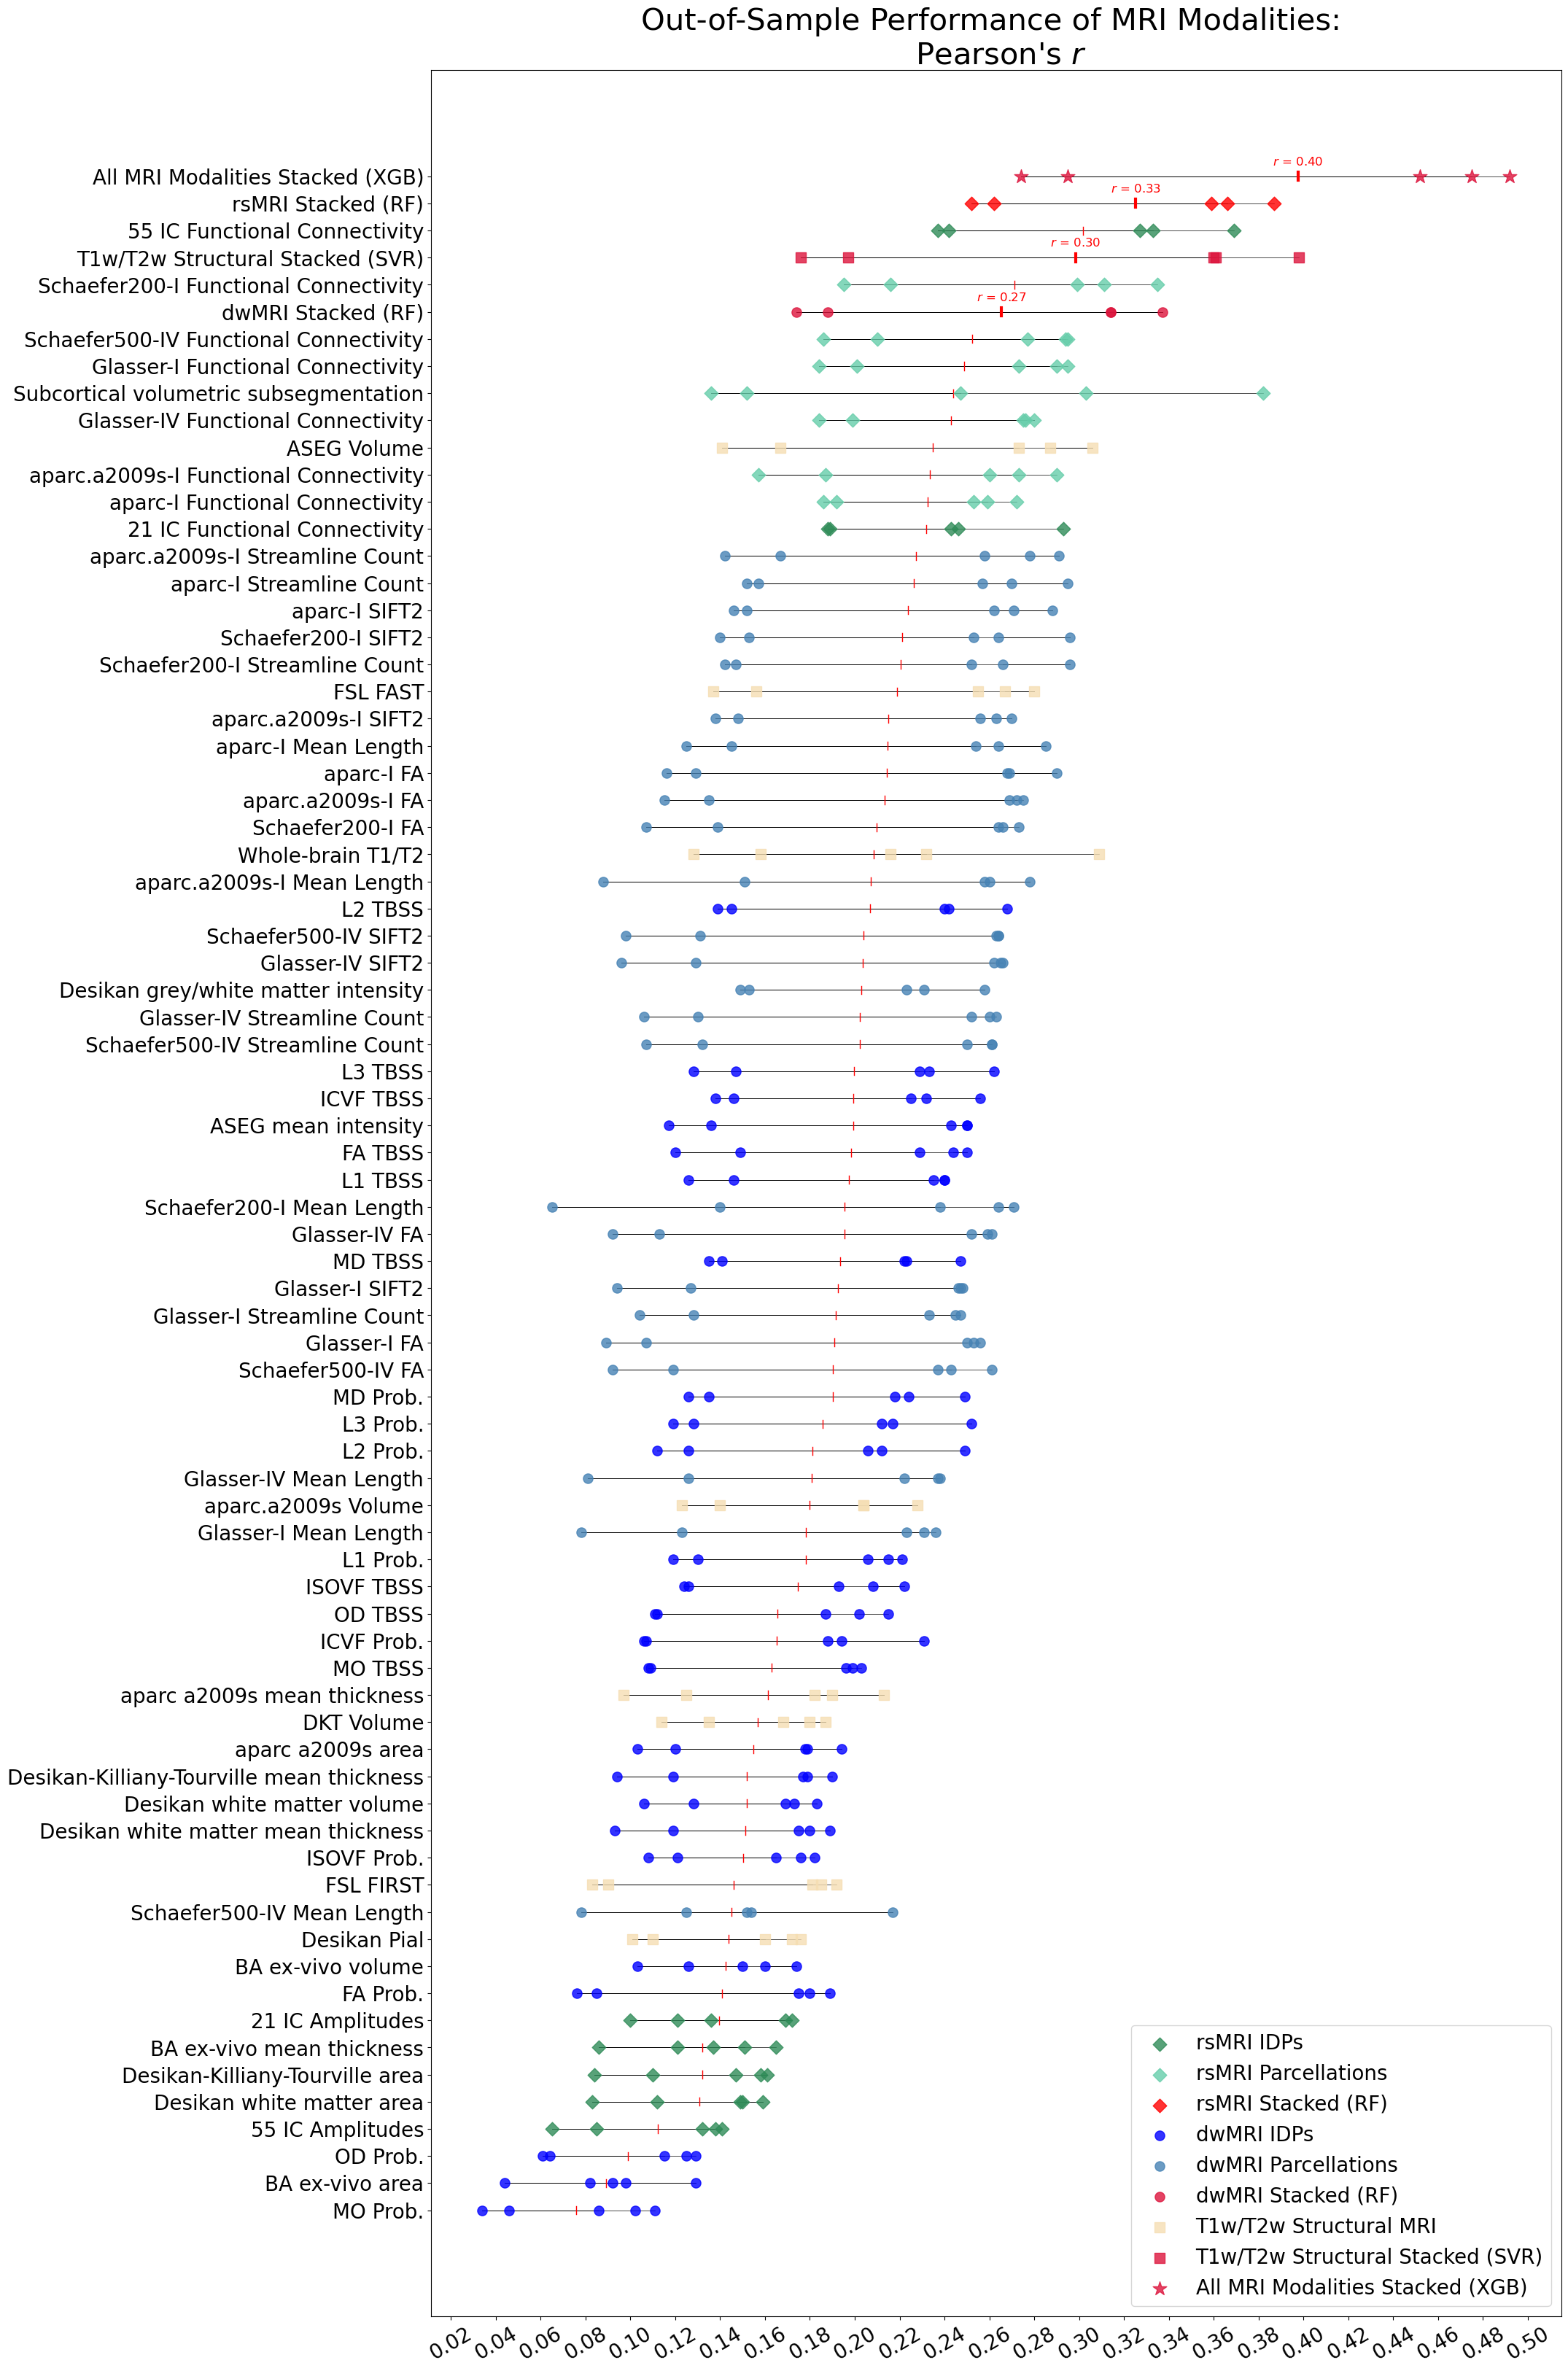

In [ ]:
plt.figure(figsize=(20, 40))

legend_order = [
    'rsMRI IDPs',
    'rsMRI Parcellations',
    'rsMRI Stacked (RF)',
    'dwMRI IDPs',
    'dwMRI Parcellations',
    'dwMRI Stacked (RF)',
    'T1w/T2w Structural MRI',
    'T1w/T2w Structural Stacked (SVR)',
    'All MRI Modalities Stacked (XGB)']

label_used = {label: False for label in legend_order}

for i, modality in enumerate(all_modalities_plus_stacked_grouped_reindex_r['Modality']):
    y = [i + 1] * len(all_modalities_plus_stacked_plot_r[all_modalities_plus_stacked_plot_r['Modality'] == modality]['Pearson r'])
    x = all_modalities_plus_stacked_plot_r[all_modalities_plus_stacked_plot_r['Modality'] == modality]['Pearson r']

    if modality in rs_idp:
        color = 'seagreen'
        marker='D'
        s=90
        label = 'rsMRI IDPs'

    elif modality in rs_parcellations:
        color = 'mediumaquamarine'
        marker='D'
        s=90
        label = 'rsMRI Parcellations'

    elif modality == 'rsMRI Stacked (RF)':
        color = 'red'
        marker='D'
        s=90
        label = 'rsMRI Stacked (RF)'

    elif modality in dti_idp:
        color = 'blue'
        marker='o'
        s=90
        label = 'dwMRI IDPs'
        
    elif modality in dti_parcellations:
        color = 'steelblue'
        marker='o'
        s=90
        label = 'dwMRI Parcellations'

    elif modality == 'dwMRI Stacked (RF)':
        color = 'crimson'
        marker='o'
        s=90
        label = 'dwMRI Stacked (RF)'

    elif modality in t1t2_modalities:
        color = 'wheat'
        marker= 's'
        s=90
        label = 'T1w/T2w Structural MRI'

    elif modality == 'T1w/T2w Structural Stacked (SVR)':
        color = 'crimson'
        marker= 's'
        s=90
        label = 'T1w/T2w Structural Stacked (SVR)'

    elif modality == 'All MRI Modalities Stacked (XGB)':
        color = 'crimson'
        marker= '*'
        s=200
        label = 'All MRI Modalities Stacked (XGB)'

    else:
        label = None

    # Only add the label if it hasn't been used yet
    if label and not label_used[label]:
        plt.scatter(x, y, color=color, marker=marker, s=s, zorder=3, alpha=0.8, label=label)
        label_used[label] = True
    else:
        plt.scatter(x, y, color=color, marker=marker, s=s, zorder=3, alpha=0.8)

    #plt.scatter(x, y, color=color, marker=marker, s=s, zorder=3, alpha=0.8, label=label)
    plt.plot(x, y, color='black', linewidth=0.5)

    # Calculate the mean across 5 folds and plot a red line
    mean_value = np.mean(all_modalities_plus_stacked_plot_r[all_modalities_plus_stacked_plot_r['Modality'] == modality]['Pearson r'])
    plt.plot([mean_value, mean_value], [i + 0.85, i + 1.15], color='red', linewidth=1)
    
    if modality in ['rsMRI Stacked (RF)', 'dwMRI Stacked (RF)', 'T1w/T2w Structural Stacked (SVR)', 'All MRI Modalities Stacked (XGB)']:
        plt.plot([mean_value, mean_value], [i + 0.85, i + 1.15], color='red', linewidth=3)
        plt.text(mean_value, i + 1.4, f'$r$ = {mean_value:.2f}', color='red', fontsize=12, ha='center')

        #plt.axvline(x=mean_value, color='grey', linestyle='--', linewidth=0.5)

# Remove duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ordered_handles = [by_label[label] for label in legend_order if label in by_label]
plt.legend(ordered_handles, legend_order, fontsize=20, loc='lower right')
#plt.legend(by_label.values(), by_label.keys(), fontsize=15) #, loc='lower right'

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.02))
plt.yticks(range(1, len(all_modalities_plus_stacked_grouped_reindex_r['Modality']) + 1), all_modalities_plus_stacked_grouped_reindex_r['Modality'], fontsize=20)
plt.xticks(fontsize=20, rotation=30)
#plt.xlabel("Pearson's $r$", fontsize=20)
plt.title("Out-of-Sample Performance of MRI Modalities: \n Pearson's $r$", fontsize=30)
plt.savefig('/IBu/Articles-Conferences/Articles/1.JAMA/Plots_and_Tables/pls_stack/PLS_Stacking_All_Mod_r.png',
                    bbox_inches="tight", 
                    pad_inches=1,
                    transparent=False, 
                    facecolor="w", 
                    edgecolor='w', 
                    #orientation='landscape'
                    )
plt.show()

### R2

In [ ]:
rs_full_r2 = pd.read_csv('/PLS/brain/stacking/rs_pls_stack_plot_r2.csv')
dti_full_r2 = pd.read_csv('/PLS/brain/stacking/dti_pls_stack_plot_r2.csv')
t1t2_full_r2 = pd.read_csv('/PLS/brain/stacking/t1t2_pls_stack_plot_r2.csv')

In [ ]:
all_stack = pd.read_csv('/PLS/brain/stacking/All_modalities_stacked_five_folds.csv')
all_stack = all_stack[all_stack['Algorithm'] == 'xgb']
all_stack_xgb_r2 = all_stack[['Fold', 'R2']]
all_stack_xgb_r2['Modality'] = 'All MRI Modalities Stacked (XGB)'
all_modalities_plus_stacked_plot_r2 = pd.concat([dti_full_r2, rs_full_r2, t1t2_full_r2, all_stack_xgb_r2], axis = 0)

In [123]:
# Rename modalities for plotting
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].astype(str).str.replace('aparc MSA I Full correlation', 'aparc-I Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('aparc a2009s MSA I Full correlation', 'aparc.a2009s-I Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Glasser MSA I Full correlation', 'Glasser-I Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Glasser MSA IV Full correlation', 'Glasser-IV Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Schaefer7n200p MSA I Full correlation', 'Schaefer200-I Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Schaefer7n500p MSA IV Full correlation', 'Schaefer500-IV Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Amplitudes 21 IC', '55 IC Amplitudes', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Amplitudes 55 IC', '21 IC Amplitudes', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Tangent matrices 21 IC', '21 IC Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Tangent matrices 55 IC', '55 IC Functional Connectivity', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('aparc a2009s MSA I Connectome FA', 'aparc.a2009s-I FA', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('aparc a2009s MSA I Connectome Mean Length', 'aparc.a2009s-I Mean Length', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('aparc a2009s MSA I Connectome SIFT2', 'aparc.a2009s-I SIFT2', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('aparc a2009s MSA I Connectome Streamline Count', 'aparc.a2009s-I Streamline Count', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('aparc MSA I Connectome FA', 'aparc-I FA', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('aparc MSA I Connectome Mean Length', 'aparc-I Mean Length', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('aparc MSA I Connectome SIFT2', 'aparc-I SIFT2', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('aparc MSA I Connectome Streamline Count', 'aparc-I Streamline Count', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Glasser MSA I Connectome FA', 'Glasser-I FA', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Glasser MSA I Connectome Mean Length', 'Glasser-I Mean Length', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Glasser MSA I Connectome SIFT2', 'Glasser-I SIFT2', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Glasser MSA I Connectome Streamline Count', 'Glasser-I Streamline Count', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Glasser MSA IV Connectome FA', 'Glasser-IV FA', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Glasser MSA IV Connectome Mean Length', 'Glasser-IV Mean Length', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Glasser MSA IV Connectome SIFT2', 'Glasser-IV SIFT2', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Glasser MSA IV Connectome Streamline Count', 'Glasser-IV Streamline Count', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Schaefer7n200p MSA I Connectome FA', 'Schaefer200-I FA', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Schaefer7n200p MSA I Connectome Mean Length', 'Schaefer200-I Mean Length', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Schaefer7n200p MSA I Connectome SIFT2', 'Schaefer200-I SIFT2', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Schaefer7n200p MSA I Connectome Streamline Count', 'Schaefer200-I Streamline Count', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Schaefer7n500p MSA IV Connectome FA', 'Schaefer500-IV FA', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Schaefer7n500p MSA IV Connectome Mean Length', 'Schaefer500-IV Mean Length', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Schaefer7n500p MSA IV Connectome SIFT2', 'Schaefer500-IV SIFT2', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Schaefer7n500p MSA IV Connectome Streamline Count', 'Schaefer500-IV Streamline Count', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('FA Probabilistic', 'FA Prob.', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('MD Probabilistic', 'MD Prob.', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('L1 Probabilistic', 'L1 Prob.', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('L2 Probabilistic', 'L2 Prob.', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('L3 Probabilistic', 'L3 Prob.', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('MO Probabilistic', 'MO Prob.', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('OD Probabilistic', 'OD Prob.', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('ICVF Probabilistic', 'ICVF Prob.', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('ISOVF Probabilistic', 'ISOVF Prob.', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('aparc a2009s Area', 'aparc.a2009s Area', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('aparc a2009s Mean Thickness', 'aparc.a2009s Mean Thickness', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('aparc a2009s volume', 'aparc.a2009s Volume', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Desikan-Killiany-Tourville Area', 'DKT Area', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Desikan-Killiany-Tourville Mean Thickness', 'DKT Mean Thickness', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Desikan-Killiany-Tourville volume', 'DKT Volume', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Desikan Grey/White Matter intensity', 'Desikan GM/WM Intensity', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Desikan pial', 'Desikan Pial', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Desikan White Matter Area', 'Desikan WM Area', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Desikan White Matter Mean Thickness', 'Desikan WM Mean Thickness', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Desikan White Matter volume', 'Desikan WM Volume', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('Subcortical Volumetric Subsegmentation', 'Subcor. Volumetric Subsegment.', regex=True)
all_modalities_plus_stacked_plot_r2['Modality'] = all_modalities_plus_stacked_plot_r2['Modality'].str.replace('ASEG volume', 'ASEG Volume', regex=True)

In [124]:
# Arrange values for plotting
all_modalities_plus_stacked_plot_r2_grouped = all_modalities_plus_stacked_plot_r2.groupby('Modality')['R2'].apply(list).reset_index(name='R2 values')
all_modalities_plus_stacked_plot_r2_grouped_sort = all_modalities_plus_stacked_plot_r2.groupby('Modality')['R2'].mean().reset_index(name='Mean R2 values').sort_values(by='Mean R2 values', ascending = True)
all_modalities_plus_stacked_plot_r2_new_index = all_modalities_plus_stacked_plot_r2_grouped_sort.index
all_modalities_plus_stacked_grouped_r2eindex_r2 = all_modalities_plus_stacked_plot_r2_grouped.reindex(all_modalities_plus_stacked_plot_r2_new_index)
all_modalities_plus_stacked_grouped_r2eindex_r2 = all_modalities_plus_stacked_grouped_r2eindex_r2.reset_index(drop=True)
all_modalities_plus_stacked_grouped_r2eindex_r2

,Modality,R2 values
0,MO Prob.,"[0.007, 0.001, 0.001, 0.01, 0.012]"
1,BA ex-vivo area,"[0.009, 0.0, 0.007, 0.016, 0.007]"
2,OD Prob.,"[0.013, 0.004, 0.003, 0.015, 0.016]"
3,55 IC Amplitudes,"[0.02, 0.002, 0.007, 0.017, 0.018]"
4,Desikan white matter area,"[0.022, 0.006, 0.012, 0.025, 0.021]"
...,...,...
71,dwMRI Stacked (RF),"[0.096, 0.031, 0.028, 0.111, 0.097]"
72,55 IC Functional Connectivity,"[0.135, 0.05, 0.048, 0.101, 0.108]"
73,T1w/T2w Structural Stacked (SVR),"[0.129, 0.037, 0.029, 0.127, 0.154]"
74,rsMRI Stacked (RF),"[0.148, 0.063, 0.059, 0.131, 0.126]"


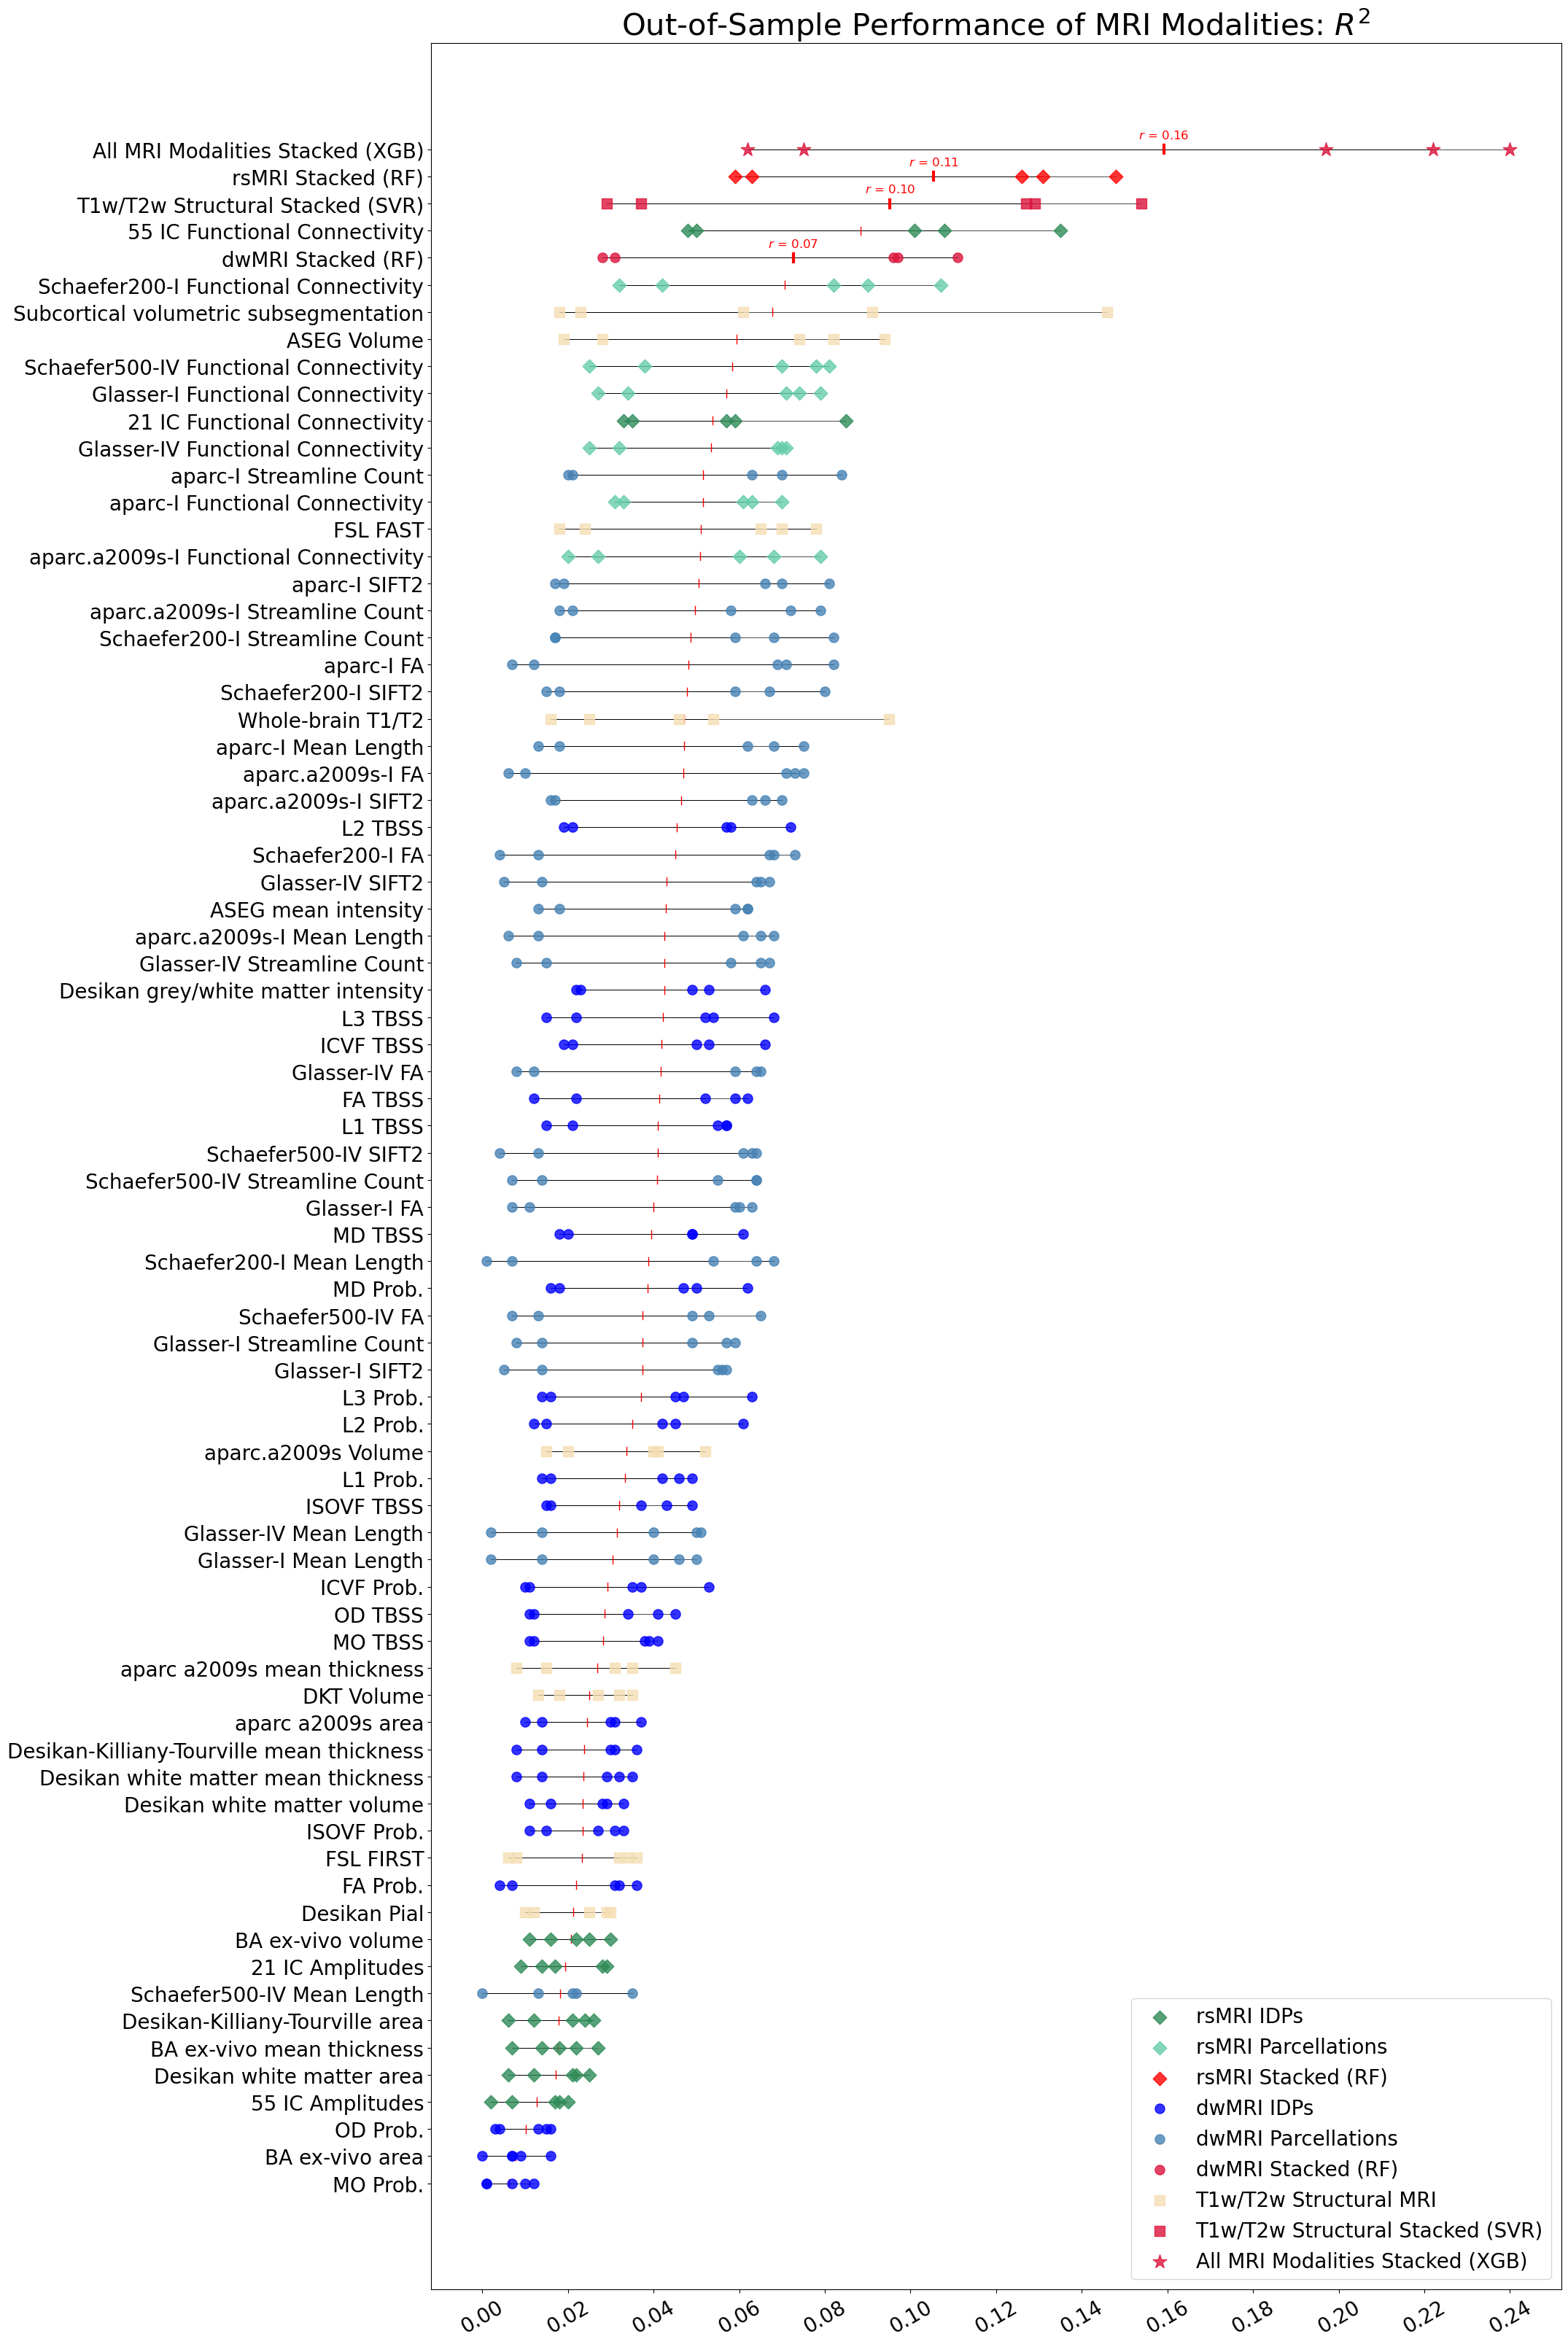

In [ ]:
plt.figure(figsize=(20, 40))

legend_order = [
    'rsMRI IDPs',
    'rsMRI Parcellations',
    'rsMRI Stacked (RF)',
    'dwMRI IDPs',
    'dwMRI Parcellations',
    'dwMRI Stacked (RF)',
    'T1w/T2w Structural MRI',
    'T1w/T2w Structural Stacked (SVR)',
    'All MRI Modalities Stacked (XGB)']

label_used = {label: False for label in legend_order}

for i, modality in enumerate(all_modalities_plus_stacked_grouped_r2eindex_r2['Modality']):
    y = [i + 1] * len(all_modalities_plus_stacked_plot_r2[all_modalities_plus_stacked_plot_r2['Modality'] == modality]['R2'])
    x = all_modalities_plus_stacked_plot_r2[all_modalities_plus_stacked_plot_r2['Modality'] == modality]['R2']

    if modality in rs_idp:
        color = 'seagreen'
        marker='D'
        s=90
        label = 'rsMRI IDPs'

    elif modality in rs_parcellations:
        color = 'mediumaquamarine'
        marker='D'
        s=90
        label = 'rsMRI Parcellations'

    elif modality == 'rsMRI Stacked (RF)':
        color = 'red'
        marker='D'
        s=90
        label = 'rsMRI Stacked (RF)'

    elif modality in dti_idp:
        color = 'blue'
        marker='o'
        s=90
        label = 'dwMRI IDPs'
        
    elif modality in dti_parcellations:
        color = 'steelblue'
        marker='o'
        s=90
        label = 'dwMRI Parcellations'

    elif modality == 'dwMRI Stacked (RF)':
        color = 'crimson'
        marker='o'
        s=90
        label = 'dwMRI Stacked (RF)'

    elif modality in t1t2_modalities:
        color = 'wheat'
        marker= 's'
        s=90
        label = 'T1w/T2w Structural MRI'

    elif modality == 'T1w/T2w Structural Stacked (SVR)':
        color = 'crimson'
        marker= 's'
        s=90
        label = 'T1w/T2w Structural Stacked (SVR)'

    elif modality == 'All MRI Modalities Stacked (XGB)':
        color = 'crimson'
        marker= '*'
        s=200
        label = 'All MRI Modalities Stacked (XGB)'

    else:
        label = None

    # Only add the label if it hasn't been used yet
    if label and not label_used[label]:
        plt.scatter(x, y, color=color, marker=marker, s=s, zorder=3, alpha=0.8, label=label)
        label_used[label] = True
    else:
        plt.scatter(x, y, color=color, marker=marker, s=s, zorder=3, alpha=0.8)

    #plt.scatter(x, y, color=color, marker=marker, s=s, zorder=3, alpha=0.8, label=label)
    plt.plot(x, y, color='black', linewidth=0.5)

    # Calculate the mean across 5 folds and plot a red line
    mean_value = np.mean(all_modalities_plus_stacked_plot_r2[all_modalities_plus_stacked_plot_r2['Modality'] == modality]['R2'])
    plt.plot([mean_value, mean_value], [i + 0.85, i + 1.15], color='red', linewidth=1)
    
    if modality in ['rsMRI Stacked (RF)', 'dwMRI Stacked (RF)', 'T1w/T2w Structural Stacked (SVR)', 'All MRI Modalities Stacked (XGB)']:
        plt.plot([mean_value, mean_value], [i + 0.85, i + 1.15], color='red', linewidth=3)
        plt.text(mean_value, i + 1.4, f'$r$ = {mean_value:.2f}', color='red', fontsize=12, ha='center')

        #plt.axvline(x=mean_value, color='grey', linestyle='--', linewidth=0.5)

# Remove duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ordered_handles = [by_label[label] for label in legend_order if label in by_label]
plt.legend(ordered_handles, legend_order, fontsize=20, loc='lower right')
#plt.legend(by_label.values(), by_label.keys(), fontsize=15) #, loc='lower right'

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.02))
plt.yticks(range(1, len(all_modalities_plus_stacked_grouped_r2eindex_r2['Modality']) + 1), all_modalities_plus_stacked_grouped_r2eindex_r2['Modality'], fontsize=20)
plt.xticks(fontsize=20, rotation=30)
#plt.xlabel("Pearson's $r$", fontsize=20)
plt.title("Out-of-Sample Performance of MRI Modalities: $R^2$", fontsize=30)
plt.savefig('/IBu/Articles-Conferences/Articles/1.JAMA/Plots_and_Tables/pls_stack/PLS_Stacking_All_Mod_R2.png',
                    bbox_inches="tight", 
                    pad_inches=1,
                    transparent=False, 
                    facecolor="w", 
                    edgecolor='w', 
                    #orientation='landscape'
                    )
plt.show()